<a href="https://colab.research.google.com/github/Y-golabchi/ARMA-2024/blob/main/EDZ_MLP_Golabchi_ARMA2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# **One Hot-encoded for Young's Modulus variable & Normalizing the data & Performing the Correlation Matrix**

In [2]:
# Reading the excel file

EDZ = pd.read_excel('/content/EDZ_input_data_Final.xlsx')

In [3]:
EDZ.columns

Index(['Run No.', 'Run No..1', 'File Name', 'Young's Modulus', 'UCS', 'CI',
       'T', 'mb peak', 's peak', 'Sig1', 'Sig3', 'SigMax', 'SigZ', 'HDZ',
       'EDZi', 'EDZo', 'HDZ/a', 'EDZi/a', 'EDZo/a'],
      dtype='object')

In [4]:
#Droping the first row (units)
EDZ.drop(0, axis=0, inplace=True)

# One-Hot encoding for Young's Modulus (E)
youngs_modulus_dummies = pd.get_dummies(EDZ["Young's Modulus"], prefix='E')

# Concatenate the dummy variables with the original DataFrame
EDZ = pd.concat([EDZ, youngs_modulus_dummies], axis=1)

# Drop the original 'Young's Modulus' column
EDZ = EDZ.drop("Young's Modulus", axis=1)

EDZ

,Run No.,Run No..1,File Name,UCS,CI,T,mb peak,s peak,Sig1,Sig3,...,SigZ,HDZ,EDZi,EDZo,HDZ/a,EDZi/a,EDZo/a,E_15000,E_40000,E_75000
1,438.0,438.0,Shale_KHh1p5_plastic_UCS52,51.82,17.32,2.165,0.298704,0.012480,13.5,9,...,5.4,0.5,1.2,1.9,1.153846,1.369231,1.584615,1,0,0
2,439.0,439.0,Shale_KHh1p5_plastic_UCS19,18.77,7.56,0.945,0.522712,0.026317,13.5,9,...,5.4,0.8,2.3,4.8,1.246154,1.707692,2.476923,1,0,0
3,441.0,441.0,Shale_KHh1p5_plastic_UCS58,57.84,24.84,3.105,0.633665,0.034017,13.5,9,...,5.4,0.3,0.5,0.8,1.092308,1.153846,1.246154,1,0,0
4,442.0,442.0,Shale_KHh1p5_plastic_UCS51,50.66,18.68,2.335,0.401074,0.018486,13.5,9,...,5.4,0.5,1.2,1.75,1.153846,1.369231,1.538462,1,0,0
5,443.0,443.0,Shale_KHh1p5_plastic_UCS44,44.09,19.6,2.45,0.702810,0.039054,13.5,9,...,5.4,0.6,1.2,1.6,1.184615,1.369231,1.492308,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,NaN,NaN,Limestone_KHh1p5_plastic_UCS140,146.87,41.36,5.17,0.178662,0.006289,94,87,...,67,1.35,2.43,4.8,1.415385,1.747692,2.476923,0,1,0
422,NaN,NaN,Limestone_KHh1p5_plastic_UCS141,121.64,44.05,5.50625,0.379926,0.017198,54,23,...,20,0.75,1.4,2.47,1.230769,1.430769,1.76,0,1,0
423,NaN,NaN,Limestone_KHh1p5_plastic_UCS142,121.64,44.05,5.50625,0.379926,0.017198,63,31,...,24,0.75,1.7,2.98,1.230769,1.523077,1.916923,0,1,0
424,NaN,NaN,Limestone_KHh1p5_plastic_UCS143,121.64,44.05,5.50625,0.379926,0.017198,76,65,...,48,1.34,2.63,4.3,1.412308,1.809231,2.323077,0,1,0


In [5]:
# Rearranging the Columns

EDZ = EDZ[['Run No.', 'Run No..1', 'File Name', 'E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T', 'mb peak',
           's peak', 'Sig1', 'Sig3', 'SigMax', 'SigZ', 'HDZ', 'EDZi', 'EDZo', 'HDZ/a', 'EDZi/a', 'EDZo/a']]

EDZ

,Run No.,Run No..1,File Name,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,...,Sig1,Sig3,SigMax,SigZ,HDZ,EDZi,EDZo,HDZ/a,EDZi/a,EDZo/a
1,438.0,438.0,Shale_KHh1p5_plastic_UCS52,1,0,0,51.82,17.32,2.165,0.298704,...,13.5,9,31.5,5.4,0.5,1.2,1.9,1.153846,1.369231,1.584615
2,439.0,439.0,Shale_KHh1p5_plastic_UCS19,1,0,0,18.77,7.56,0.945,0.522712,...,13.5,9,31.5,5.4,0.8,2.3,4.8,1.246154,1.707692,2.476923
3,441.0,441.0,Shale_KHh1p5_plastic_UCS58,1,0,0,57.84,24.84,3.105,0.633665,...,13.5,9,31.5,5.4,0.3,0.5,0.8,1.092308,1.153846,1.246154
4,442.0,442.0,Shale_KHh1p5_plastic_UCS51,1,0,0,50.66,18.68,2.335,0.401074,...,13.5,9,31.5,5.4,0.5,1.2,1.75,1.153846,1.369231,1.538462
5,443.0,443.0,Shale_KHh1p5_plastic_UCS44,1,0,0,44.09,19.6,2.45,0.702810,...,13.5,9,31.5,5.4,0.6,1.2,1.6,1.184615,1.369231,1.492308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,NaN,NaN,Limestone_KHh1p5_plastic_UCS140,0,1,0,146.87,41.36,5.17,0.178662,...,94,87,195.0,67,1.35,2.43,4.8,1.415385,1.747692,2.476923
422,NaN,NaN,Limestone_KHh1p5_plastic_UCS141,0,1,0,121.64,44.05,5.50625,0.379926,...,54,23,139.0,20,0.75,1.4,2.47,1.230769,1.430769,1.76
423,NaN,NaN,Limestone_KHh1p5_plastic_UCS142,0,1,0,121.64,44.05,5.50625,0.379926,...,63,31,158.0,24,0.75,1.7,2.98,1.230769,1.523077,1.916923
424,NaN,NaN,Limestone_KHh1p5_plastic_UCS143,0,1,0,121.64,44.05,5.50625,0.379926,...,76,65,163.0,48,1.34,2.63,4.3,1.412308,1.809231,2.323077


In [6]:
# Convert specific columns to float64
columns_to_convert = ['Run No.', 'Run No..1', 'UCS', 'CI',
       'T', 'mb peak', 's peak', 'Sig1', 'Sig3', 'SigMax', 'SigZ', 'HDZ',
       'EDZi', 'EDZo', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'E_15000',
                      'E_75000', 'E_40000']
EDZ[columns_to_convert] = EDZ[columns_to_convert].astype(float)

print(EDZ.dtypes)

Run No.      float64
Run No..1    float64
File Name     object
E_15000      float64
E_40000      float64
E_75000      float64
UCS          float64
CI           float64
T            float64
mb peak      float64
s peak       float64
Sig1         float64
Sig3         float64
SigMax       float64
SigZ         float64
HDZ          float64
EDZi         float64
EDZo         float64
HDZ/a        float64
EDZi/a       float64
EDZo/a       float64
dtype: object


In [7]:
# Delete these columns: 'Run No.', 'Run No..1', 'File Name', 'HDZ', 'EDZi', 'EDZo'

EDZ.drop(['Run No.', 'Run No..1', 'File Name', 'HDZ', 'EDZi', 'EDZo', 'SigMax'], axis=1, inplace=True)


In [8]:
print(EDZ.columns)
EDZ

Index(['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T', 'mb peak', 's peak',
       'Sig1', 'Sig3', 'SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'],
      dtype='object')


,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,s peak,Sig1,Sig3,SigZ,HDZ/a,EDZi/a,EDZo/a
1,1.0,0.0,0.0,51.82,17.32,2.16500,0.298704,0.012480,13.5,9.0,5.4,1.153846,1.369231,1.584615
2,1.0,0.0,0.0,18.77,7.56,0.94500,0.522712,0.026317,13.5,9.0,5.4,1.246154,1.707692,2.476923
3,1.0,0.0,0.0,57.84,24.84,3.10500,0.633665,0.034017,13.5,9.0,5.4,1.092308,1.153846,1.246154
4,1.0,0.0,0.0,50.66,18.68,2.33500,0.401074,0.018486,13.5,9.0,5.4,1.153846,1.369231,1.538462
5,1.0,0.0,0.0,44.09,19.60,2.45000,0.702810,0.039054,13.5,9.0,5.4,1.184615,1.369231,1.492308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,1.0,0.0,146.87,41.36,5.17000,0.178662,0.006289,94.0,87.0,67.0,1.415385,1.747692,2.476923
422,0.0,1.0,0.0,121.64,44.05,5.50625,0.379926,0.017198,54.0,23.0,20.0,1.230769,1.430769,1.760000
423,0.0,1.0,0.0,121.64,44.05,5.50625,0.379926,0.017198,63.0,31.0,24.0,1.230769,1.523077,1.916923
424,0.0,1.0,0.0,121.64,44.05,5.50625,0.379926,0.017198,76.0,65.0,48.0,1.412308,1.809231,2.323077


In [9]:
# Specify the columns you want to normalize
columns_to_normalize = ['UCS', 'CI', 'T', 'mb peak', 's peak',
                        'Sig1','Sig3', 'SigZ']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling to the specified columns
EDZ[columns_to_normalize] = scaler.fit_transform(EDZ[columns_to_normalize])

EDZ

,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,s peak,Sig1,Sig3,SigZ,HDZ/a,EDZi/a,EDZo/a
1,1.0,0.0,0.0,0.122485,0.059447,0.059447,0.049226,0.024099,0.000000,0.021303,0.000000,1.153846,1.369231,1.584615
2,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.122340,0.071700,0.000000,0.021303,0.000000,1.246154,1.707692,2.476923
3,1.0,0.0,0.0,0.144795,0.105250,0.105250,0.158554,0.098190,0.000000,0.021303,0.000000,1.092308,1.153846,1.246154
4,1.0,0.0,0.0,0.118186,0.067731,0.067731,0.082639,0.044762,0.000000,0.021303,0.000000,1.153846,1.369231,1.538462
5,1.0,0.0,0.0,0.093837,0.073334,0.073334,0.181122,0.115518,0.000000,0.021303,0.000000,1.184615,1.369231,1.492308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,1.0,0.0,0.474743,0.205872,0.205872,0.010046,0.002803,0.363431,0.759799,0.773869,1.415385,1.747692,2.476923
422,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.182844,0.153853,0.183417,1.230769,1.430769,1.760000
423,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.223476,0.229597,0.233668,1.230769,1.523077,1.916923
424,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.282167,0.551505,0.535176,1.412308,1.809231,2.323077


In [10]:
print(EDZ.nunique())

E_15000      2
E_40000      2
E_75000      2
UCS        111
CI         108
T          118
mb peak    143
s peak     116
Sig1       123
Sig3       115
SigZ       111
HDZ/a       42
EDZi/a      94
EDZo/a     121
dtype: int64


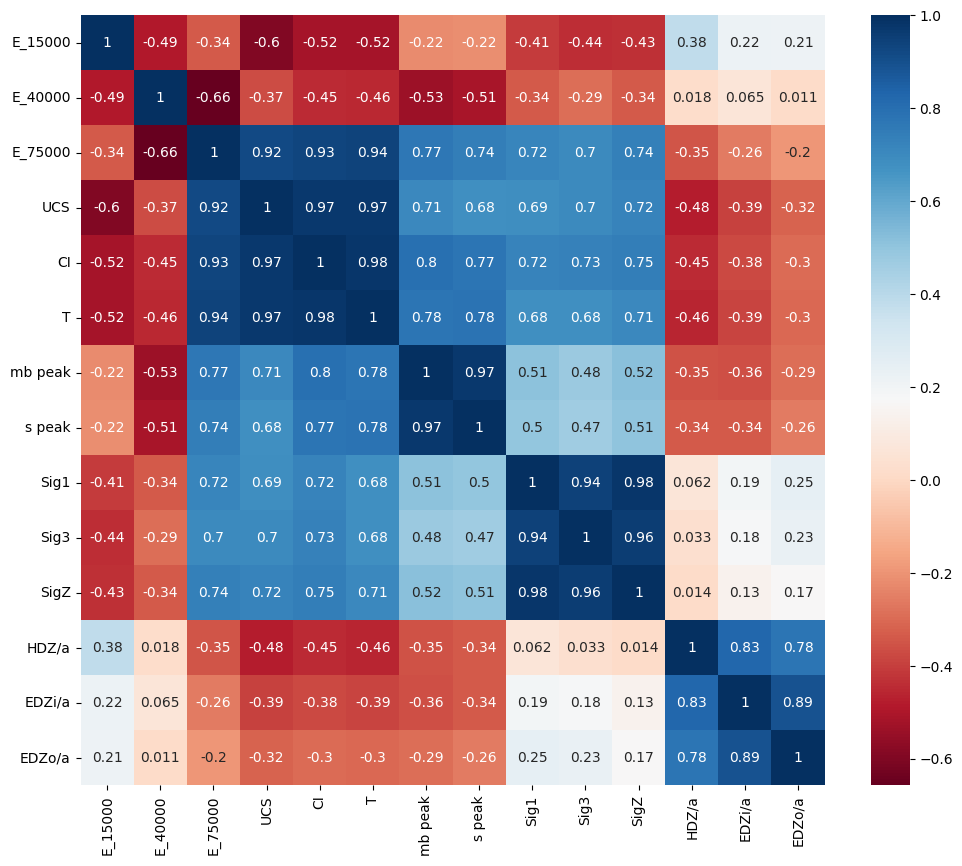

In [11]:
#Pearson Correlation
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(EDZ.corr(), annot=True, cmap='RdBu')

plt.show()

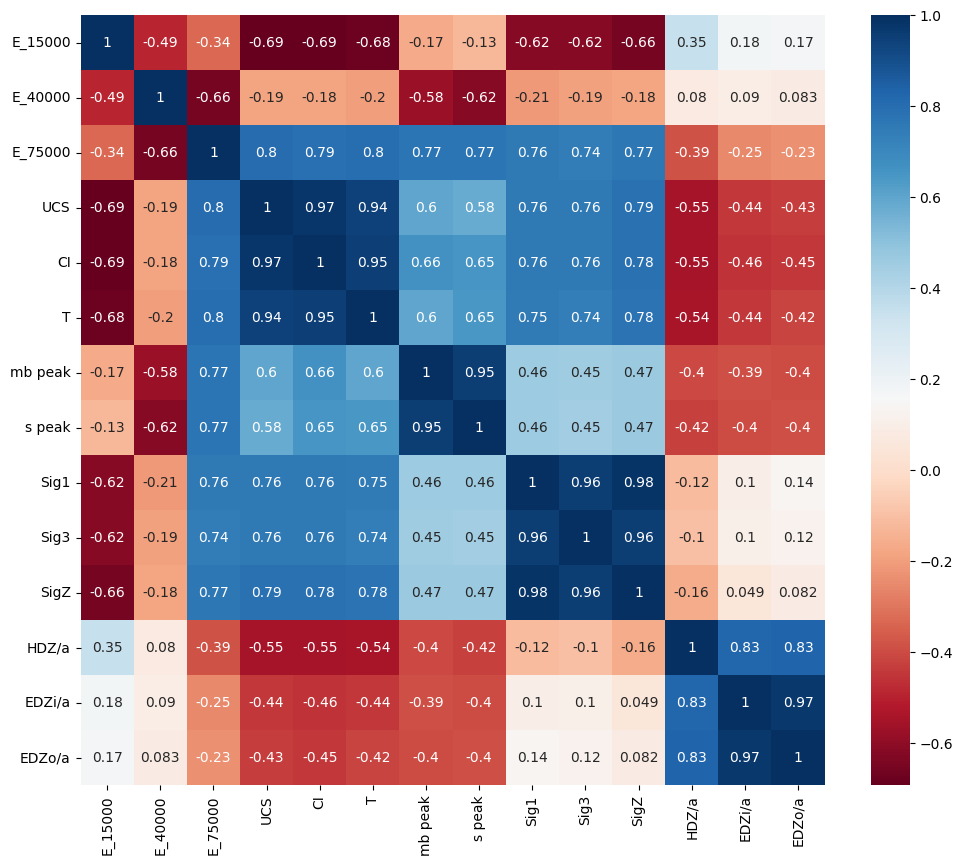

In [12]:
#Spearman Correlation
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(EDZ.corr(method='spearman'), annot=True, cmap='RdBu')

plt.show()

# **Splitting Data**

In [13]:
# Spliting the data

x_EDZ = EDZ[['E_15000','E_40000', 'E_75000','UCS','CI','T','mb peak','s peak','Sig1','Sig3','SigZ']]
y_EDZ = EDZ[['HDZ/a', 'EDZi/a', 'EDZo/a']]


In [14]:
x_EDZ

,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,s peak,Sig1,Sig3,SigZ
1,1.0,0.0,0.0,0.122485,0.059447,0.059447,0.049226,0.024099,0.000000,0.021303,0.000000
2,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.122340,0.071700,0.000000,0.021303,0.000000
3,1.0,0.0,0.0,0.144795,0.105250,0.105250,0.158554,0.098190,0.000000,0.021303,0.000000
4,1.0,0.0,0.0,0.118186,0.067731,0.067731,0.082639,0.044762,0.000000,0.021303,0.000000
5,1.0,0.0,0.0,0.093837,0.073334,0.073334,0.181122,0.115518,0.000000,0.021303,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,1.0,0.0,0.474743,0.205872,0.205872,0.010046,0.002803,0.363431,0.759799,0.773869
422,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.182844,0.153853,0.183417
423,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.223476,0.229597,0.233668
424,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.282167,0.551505,0.535176


In [15]:
y_EDZ

,HDZ/a,EDZi/a,EDZo/a
1,1.153846,1.369231,1.584615
2,1.246154,1.707692,2.476923
3,1.092308,1.153846,1.246154
4,1.153846,1.369231,1.538462
5,1.184615,1.369231,1.492308
...,...,...,...
421,1.415385,1.747692,2.476923
422,1.230769,1.430769,1.760000
423,1.230769,1.523077,1.916923
424,1.412308,1.809231,2.323077


In [16]:
# Splitting in train and test sets
x_train_EDZ, x_test_EDZ, y_train_EDZ, y_test_EDZ = train_test_split(x_EDZ, y_EDZ, test_size=0.2, random_state=7)

In [17]:
print(x_train_EDZ.shape)
print(x_test_EDZ.shape)
print(y_train_EDZ.shape)
print(y_test_EDZ.shape)

(340, 11)
(85, 11)
(340, 3)
(85, 3)


In [18]:
#Combining x & y training sets for data augmentation
x_y_training = pd.concat([x_train_EDZ, y_train_EDZ], axis=1)
x_y_training.shape

(340, 14)

# **Data Augmentation**

In [19]:
# Introduce a particular set of random numbers every time
np.random.seed(7)

# Number of augmented samples you want to generate
num_augmented_samples = 1

# Initialize an empty DataFrame to store augmented data
augmented_data = pd.DataFrame()

# Define the range for random noise and scaling
noise_range = 0.02
scaling_range = 0.1

# Loop to generate augmented samples
for _ in range(num_augmented_samples):
    # Copy the original data
    augmented_sample = x_y_training.copy()

    # Columns to exclude from augmentation
    columns_to_exclude = ['E_15000', 'E_40000', 'E_75000']

    # Add random noise to columns excluding one-hot encoded columns
    columns_to_augment = [col for col in augmented_sample.columns if col not in columns_to_exclude]
    augmented_sample[columns_to_augment] += np.random.uniform(-noise_range, noise_range, size=(len(augmented_sample), len(columns_to_augment)))

    # Multiply by a random scaling factor for columns excluding one-hot encoded columns
    augmented_sample[columns_to_augment] *= np.random.uniform(1 - scaling_range, 1 + scaling_range, size=(len(augmented_sample), len(columns_to_augment)))

    # Append the augmented sample to the DataFrame
    augmented_data = augmented_data.append(augmented_sample, ignore_index=True)

# Concatenate the original data with the augmented data
augmented_EDZ = pd.concat([x_y_training, augmented_data], ignore_index=True)

# Shuffle the rows to mix original and augmented data
augmented_EDZ_training = augmented_EDZ.sample(frac=1).reset_index(drop=True)

## **Proving Data Augmentation Does Not Inflate Data**

In [20]:
print('The shape of plain training set would be: ',x_y_training.shape)
print('The shape of augmented training set would be: ',augmented_EDZ_training.shape)

The shape of plain training set would be:  (340, 14)
The shape of augmented training set would be:  (680, 14)


### **Training Set's VIF before Data augmentation**

In [21]:
# Function to calculate VIF for a group of features
plain_training_set = x_y_training.drop(['HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)

def calculate_vif(data_frame, features):
    X = data_frame[features]
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Groups of variables
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T']
# hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']

# Calculate VIF and print for each group
vif_rock_material = calculate_vif(plain_training_set, rock_material_properties)
# vif_hoek_brown = calculate_vif(plain_training_set, hoek_brown_parameters)
vif_stress_components = calculate_vif(plain_training_set, stress_components)

print("VIF for Rock Material Properties:")
print(vif_rock_material)

# print("\nVIF for Hoek-Brown Parameters:")
# print(vif_hoek_brown)

print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.486082
1  E_40000  12.053627
2  E_75000  44.402509
3      UCS  29.679202
4       CI  22.344341
5        T  25.864064

VIF for Stress Components:
  Variable        VIF
0     Sig1  40.325047
1     Sig3  25.038288
2     SigZ  57.829872


### **Training Set's VIF after Data augmentation**

In [22]:
# Function to calculate VIF for a group of features
augmented_EDZ_All = augmented_EDZ_training.drop(['HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)

def calculate_vif(data_frame, features):
    X = data_frame[features]
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Groups of variables
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T']
# hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']

# Calculate VIF and print for each group
vif_rock_material = calculate_vif(augmented_EDZ_All, rock_material_properties)
# vif_hoek_brown = calculate_vif(augmented_EDZ_All, hoek_brown_parameters)
vif_stress_components = calculate_vif(augmented_EDZ_All, stress_components)

print("VIF for Rock Material Properties:")
print(vif_rock_material)

# print("\nVIF for Hoek-Brown Parameters:")
# print(vif_hoek_brown)

print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.440230
1  E_40000  11.015924
2  E_75000  42.333777
3      UCS  23.883664
4       CI  18.705100
5        T  21.682509

VIF for Stress Components:
  Variable        VIF
0     Sig1  33.613610
1     Sig3  22.419707
2     SigZ  46.619294


## **Splitting Augmented Training Set**

In [23]:
# After augmentation then deviding the EDZ training data to x and y
x_train_EDZ = augmented_EDZ_training[['E_15000','E_40000', 'E_75000','UCS','CI','T','mb peak','s peak','Sig1','Sig3','SigZ']]
y_train_EDZ = augmented_EDZ_training[['HDZ/a', 'EDZi/a', 'EDZo/a']]

In [24]:
print(x_train_EDZ.shape)
print(x_test_EDZ.shape)
print(y_train_EDZ.shape)
print(y_test_EDZ.shape)

(680, 11)
(85, 11)
(680, 3)
(85, 3)


# **Regression Models With All the Features**

In [25]:

# # Create an MLP regression model

# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another appropriate metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions = best_model.predict(x_test_EDZ)

# # Evaluate the performance using an appropriate metric
# test_score = r2_score(y_test_EDZ, predictions)
# print("R^2 Score on Test Data:", test_score)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (5, 5), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.8613825595516911

'''

"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (5, 5), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.8613825595516911\n\n"

In [26]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(5, 5),
    activation='relu',
    alpha=0.01,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ, y_train_EDZ)

# Make predictions on the test data
predictions = best_mlp_multioutput_regressor.predict(x_test_EDZ)

# Evaluate the performance using the R^2 score
test_score = r2_score(y_test_EDZ, predictions)
print("R^2 Score on Test Data:", test_score)


# Calculate and print the mean absolute error
test_score_mae = mean_absolute_error(y_test_EDZ, predictions)
print("\nMean Absolute Error on Test Data:", test_score_mae)

R^2 Score on Test Data: 0.839449052753101

Mean Absolute Error on Test Data: 0.06064613555490267


**The best params when the features are :Young's Modulus,	CI,	mb peak,	s peak,	Sig1,	Sig3**
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.1, 'estimator__hidden_layer_sizes': (4, 3), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.7867586285711656

## Visualizing Predictions VS. Actual Values




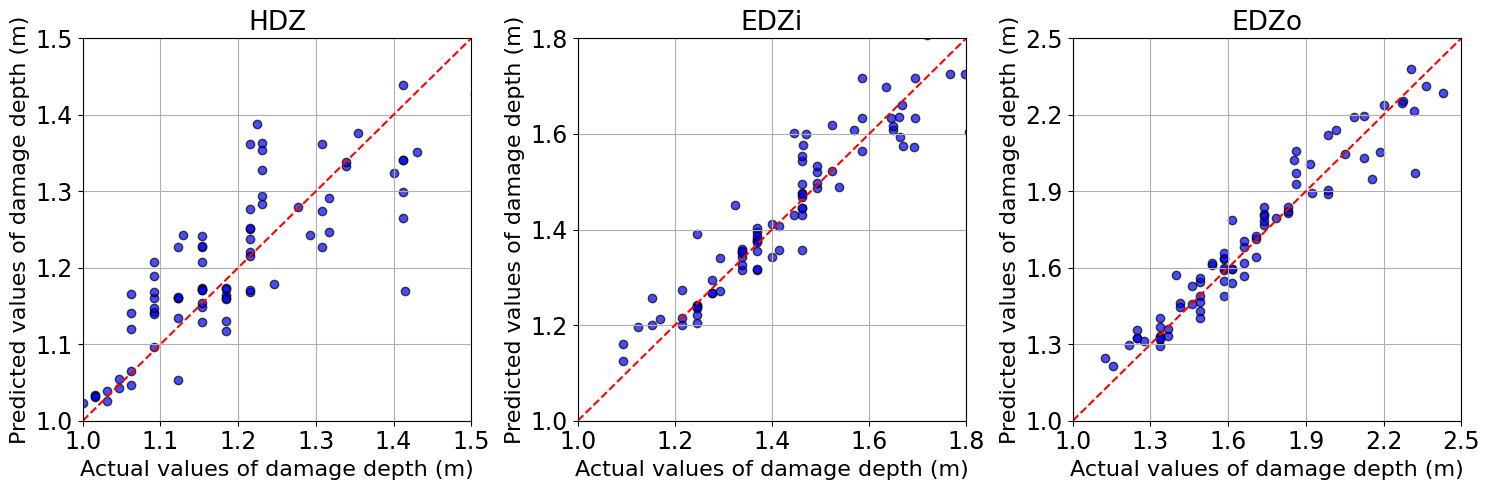

In [27]:
# Make predictions on the test data using the best model
# predictions = best_model.predict(x_test_EDZ)

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']
labels = ['HDZ', 'EDZi', 'EDZo']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(labels[i], fontsize=19)
    plt.xlabel('Actual values of damage depth (m)', fontsize=16)
    plt.ylabel('Predicted values of damage depth (m)', fontsize=16)
    plt.grid(True)



    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    if i==0:
      plt.xlim(1, 1.5)
      plt.ylim(1, 1.5)
      plt.xticks(fontsize=17)
      plt.yticks(fontsize=17)

    if i==1:
      plt.xlim(1, 1.8)
      plt.ylim(1, 1.8)
      plt.xticks(np.arange(1,1.81,0.2),fontsize=17)
      plt.yticks(np.arange(1,1.81,0.2), fontsize=17)

    if i==2:
      plt.xlim(1, 2.5)
      plt.ylim(1, 2.5)
      plt.xticks(np.arange(1,2.51,0.3), fontsize=17)
      plt.yticks(np.arange(1,2.51,0.3),fontsize=17)
    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    # plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()

plt.savefig("Visualizing Actual vs Prediction.png", format="png", dpi=600, bbox_inches='tight')

plt.show()

##Residual Analysis

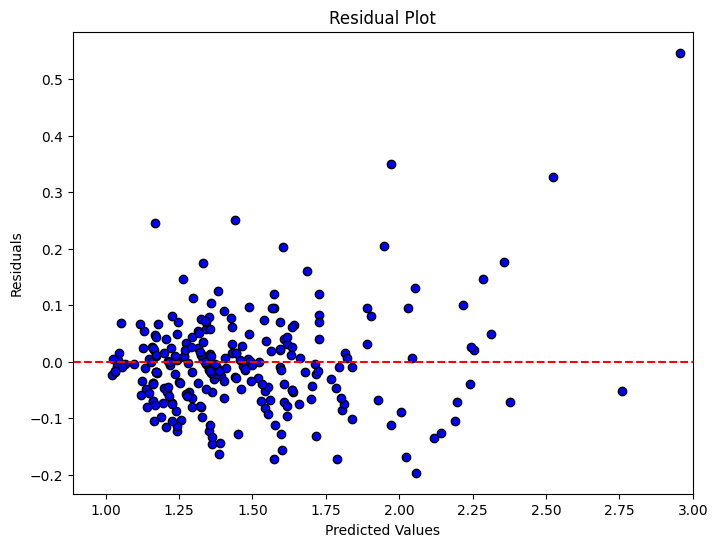

In [28]:
residuals = y_test_EDZ - predictions
plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.xlim(None,3)
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# **Regression Model without Rock Material Properties**

In [29]:
# Dropping
x_train_EDZ_Rock_Mat_Prop = x_train_EDZ.drop(['E_15000','E_40000','E_75000', 'UCS', 'CI', 'T'], axis=1, inplace=False)
x_test_EDZ_Rock_Mat_Prop = x_test_EDZ.drop(['E_15000','E_40000','E_75000', 'UCS', 'CI', 'T'], axis=1, inplace=False)

In [30]:
x_train_EDZ_Rock_Mat_Prop

,mb peak,s peak,Sig1,Sig3,SigZ
0,0.122033,0.071418,0.083511,0.114104,0.099734
1,0.183347,0.126000,0.032554,0.025447,0.029770
2,0.261922,0.208226,1.039581,0.939804,0.912407
3,0.270503,0.189510,0.091422,0.096099,0.101759
4,0.203971,0.133651,0.091422,0.149119,0.101759
...,...,...,...,...,...
675,0.057753,0.029177,0.091422,0.096099,0.101759
676,0.287517,0.207326,0.490045,0.530285,0.565700
677,0.148449,0.090629,0.000000,0.000000,0.000000
678,0.073253,0.041083,0.077305,0.106429,0.101826


In [31]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ_Rock_Mat_Prop, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_Rock_Mat_Prop = best_model.predict(x_test_EDZ_Rock_Mat_Prop)

# # Evaluate the performance using an appropriate metric
# test_score_Rock_Mat_Prop = r2_score(y_test_EDZ, predictions_Rock_Mat_Prop)
# print("R^2 Score on Test Data:", test_score_Rock_Mat_Prop)


'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (5, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.4931681214437324
'''

"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (5, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.4931681214437324\n"

In [32]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(5, 6),
    activation='relu',
    alpha=0.0001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_Rock_Mat_Prop, y_train_EDZ)

# Make predictions on the test data
predictions_Rock_Mat_Prop = best_mlp_multioutput_regressor.predict(x_test_EDZ_Rock_Mat_Prop)

# Evaluate the performance using the R^2 score
test_score_Rock_Mat_Prop = r2_score(y_test_EDZ, predictions_Rock_Mat_Prop)
print("R^2 Score on Test Data:", test_score_Rock_Mat_Prop)

# Calculate and print the mean absolute error
test_score_mae_Rock_Mat_Prop = mean_absolute_error(y_test_EDZ, predictions_Rock_Mat_Prop)
print("\nMean Absolute Error on Test Data:", test_score_mae_Rock_Mat_Prop)

R^2 Score on Test Data: 0.5873247613784799

Mean Absolute Error on Test Data: 0.11880049178013365


## Visualizing Predictions VS. Actual Values


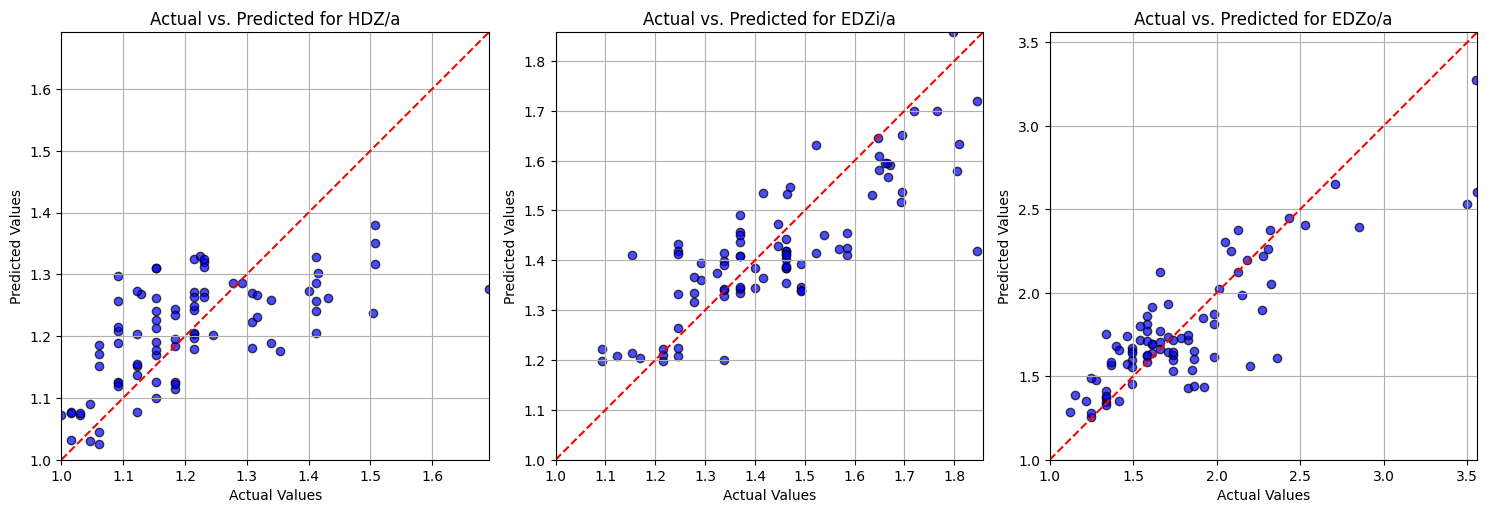

In [33]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_Rock_Mat_Prop[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_Rock_Mat_Prop[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## Residual Analysis

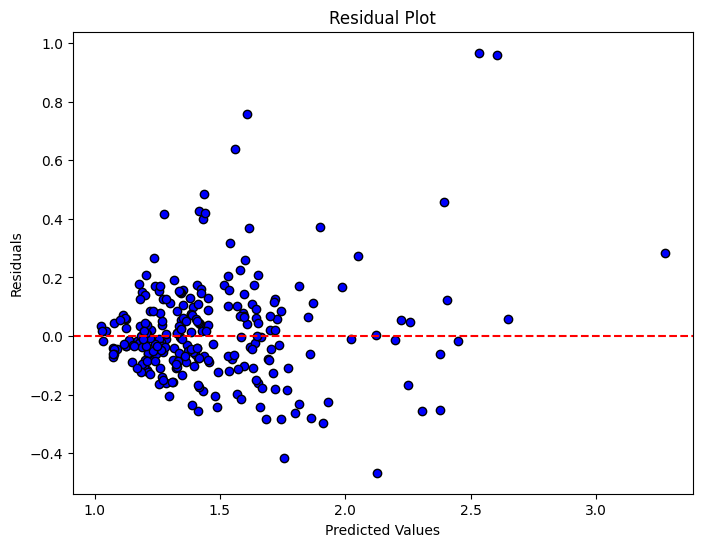

In [34]:
residuals = y_test_EDZ - predictions_Rock_Mat_Prop
plt.figure(figsize=(8, 6))
plt.scatter(predictions_Rock_Mat_Prop, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# **Regression Model without Hoek-Brown Parameters**





In [35]:
# Dropping
x_train_EDZ_HB_Comp = x_train_EDZ.drop(['mb peak', 's peak'], axis=1, inplace=False)
x_test_EDZ_HB_Comp = x_test_EDZ.drop(['mb peak', 's peak'], axis=1, inplace=False)

In [36]:
x_train_EDZ_HB_Comp

,E_15000,E_40000,E_75000,UCS,CI,T,Sig1,Sig3,SigZ
0,0.0,1.0,0.0,0.279447,0.199114,0.201162,0.083511,0.114104,0.099734
1,1.0,0.0,0.0,0.090391,0.068768,0.075208,0.032554,0.025447,0.029770
2,0.0,0.0,1.0,0.858054,0.713949,0.757737,1.039581,0.939804,0.912407
3,0.0,1.0,0.0,0.459734,0.385492,0.385492,0.091422,0.096099,0.101759
4,0.0,1.0,0.0,0.386947,0.298209,0.298209,0.091422,0.149119,0.101759
...,...,...,...,...,...,...,...,...,...
675,0.0,1.0,0.0,0.336508,0.183335,0.183335,0.091422,0.096099,0.101759
676,0.0,0.0,1.0,0.893163,0.666671,0.762400,0.490045,0.530285,0.565700
677,1.0,0.0,0.0,0.189119,0.133512,0.133512,0.000000,0.000000,0.000000
678,0.0,1.0,0.0,0.231808,0.121373,0.148502,0.077305,0.106429,0.101826


In [37]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ_HB_Comp, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_HB_Comp = best_model.predict(x_test_EDZ_HB_Comp)

# # Evaluate the performance using an appropriate metric
# test_score_HB_Comp = r2_score(y_test_EDZ, predictions_HB_Comp)
# print("R^2 Score on Test Data:", test_score_HB_Comp)



'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (5, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.8506747726571261

'''

"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (5, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.8506747726571261\n\n"

In [38]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(5, 6),
    activation='relu',
    alpha=0.01,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_HB_Comp, y_train_EDZ)

# Make predictions on the test data
predictions_HB_Comp = best_mlp_multioutput_regressor.predict(x_test_EDZ_HB_Comp)

# Evaluate the performance using the R^2 score
test_score_HB_Comp = r2_score(y_test_EDZ, predictions_HB_Comp)
print("R^2 Score on Test Data:", test_score_HB_Comp)

# Calculate and print the mean absolute error
test_score_mae_HB_Comp = mean_absolute_error(y_test_EDZ, predictions_HB_Comp)
print("\nMean Absolute Error on Test Data:", test_score_mae_HB_Comp)

R^2 Score on Test Data: 0.8553843985467205

Mean Absolute Error on Test Data: 0.05860760507961966


## Visualizing Predictions VS. Actual Values

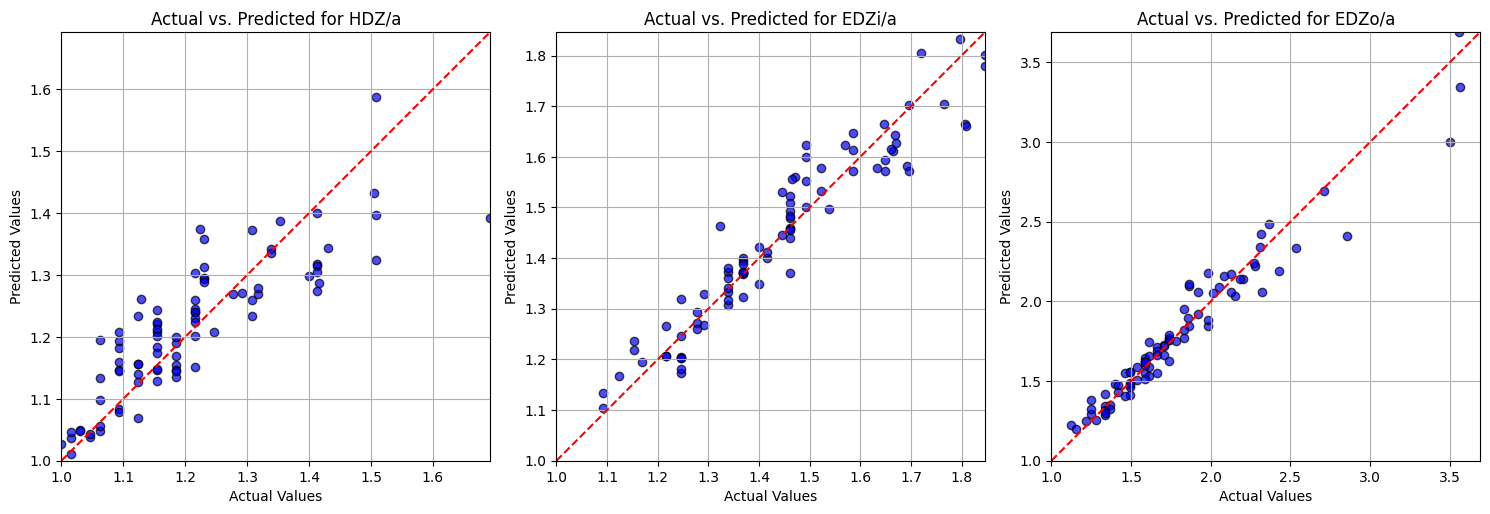

In [39]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_HB_Comp[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_HB_Comp[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## Residual Analysis

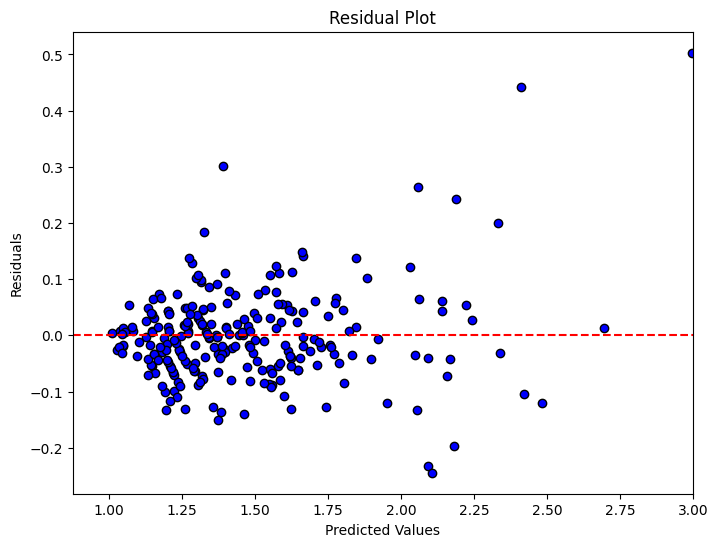

In [40]:
residuals = y_test_EDZ - predictions_HB_Comp
plt.figure(figsize=(8, 6))
plt.scatter(predictions_HB_Comp, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlim(None,3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# **Regression Model without Stress Components**

In [41]:
# Dropping
x_train_EDZ_stress = x_train_EDZ.drop(['Sig1', 'Sig3', 'SigZ'], axis=1, inplace=False)
x_test_EDZ_stress = x_test_EDZ.drop(['Sig1', 'Sig3', 'SigZ'], axis=1, inplace=False)

In [42]:
x_train_EDZ_stress

,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,s peak
0,0.0,1.0,0.0,0.279447,0.199114,0.201162,0.122033,0.071418
1,1.0,0.0,0.0,0.090391,0.068768,0.075208,0.183347,0.126000
2,0.0,0.0,1.0,0.858054,0.713949,0.757737,0.261922,0.208226
3,0.0,1.0,0.0,0.459734,0.385492,0.385492,0.270503,0.189510
4,0.0,1.0,0.0,0.386947,0.298209,0.298209,0.203971,0.133651
...,...,...,...,...,...,...,...,...
675,0.0,1.0,0.0,0.336508,0.183335,0.183335,0.057753,0.029177
676,0.0,0.0,1.0,0.893163,0.666671,0.762400,0.287517,0.207326
677,1.0,0.0,0.0,0.189119,0.133512,0.133512,0.148449,0.090629
678,0.0,1.0,0.0,0.231808,0.121373,0.148502,0.073253,0.041083


In [43]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ_stress, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_stress = best_model.predict(x_test_EDZ_stress)

# # Evaluate the performance using an appropriate metric
# test_score_stress = r2_score(y_test_EDZ, predictions_stress)
# print("R^2 Score on Test Data:", test_score_stress)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (4, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.1856979646456387
'''

"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (4, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.1856979646456387\n"

In [44]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(4, 6),
    activation='relu',
    alpha=0.01,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_stress, y_train_EDZ)

# Make predictions on the test data
predictions_stress = best_mlp_multioutput_regressor.predict(x_test_EDZ_stress)

# Evaluate the performance using the R^2 score
test_score_stress = r2_score(y_test_EDZ, predictions_stress)
print("R^2 Score on Test Data:", test_score_stress)

# Calculate and print the mean absolute error
test_score_mae_stress = mean_absolute_error(y_test_EDZ, predictions_stress)
print("\nMean Absolute Error on Test Data:", test_score_mae_stress)

R^2 Score on Test Data: 0.1941146619116693

Mean Absolute Error on Test Data: 0.18433290491109514


## Visualizing Predictions VS. Actual Values


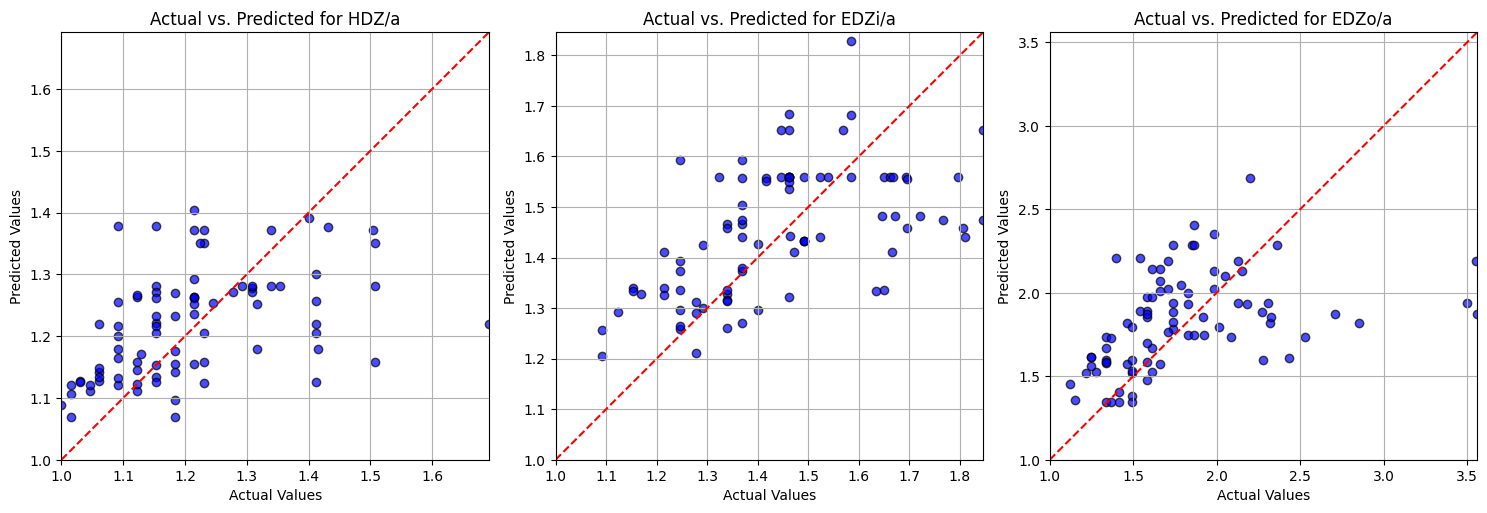

In [45]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_stress[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'Actual vs. Predicted for {target}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_stress[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## Residual Analysis

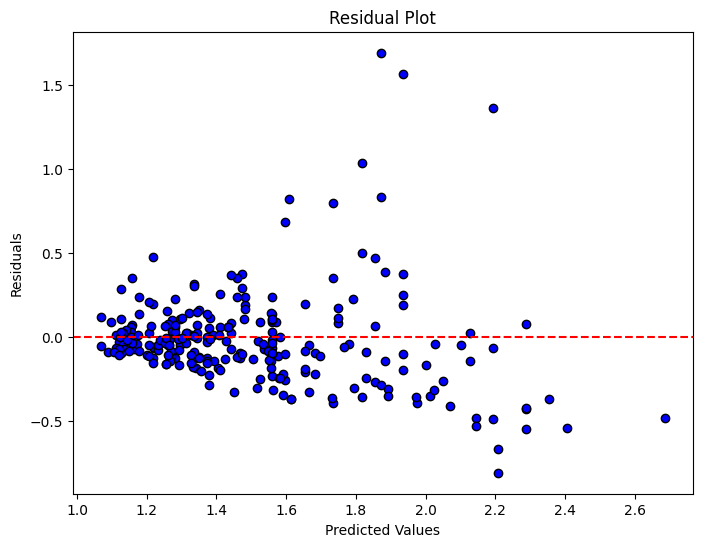

In [46]:
residuals = y_test_EDZ - predictions_stress
plt.figure(figsize=(8, 6))
plt.scatter(predictions_stress, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# **Plotting $R^2$ & $MAE$  for Different MLPS**


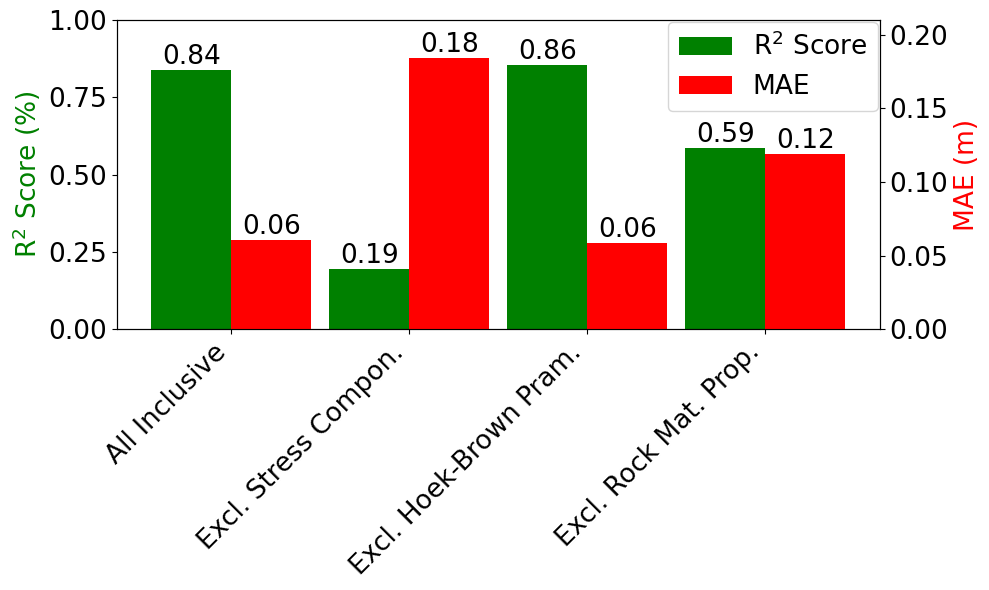

In [47]:
# the MAE and R-squared values
mae_values = (test_score_mae, test_score_mae_stress,
              test_score_mae_HB_Comp, test_score_mae_Rock_Mat_Prop)

r_squared_values = (test_score, test_score_stress,
                    test_score_HB_Comp, test_score_Rock_Mat_Prop)

# X-axis values
x_eval = np.array([1, 2, 3, 4])
my_xticks = ['All Inclusive', 'Excl. Stress Compon.', 'Excl. Hoek-Brown Pram.', 'Excl. Rock Mat. Prop.']

# Set the width of the bars
bar_width = 0.45

# Create subplots with 2 rows and 1 column
fig, axs1 = plt.subplots(figsize=(10, 6))

# Calculate positions for the bars
bar_positions_r_squared = x_eval - bar_width / 2
bar_positions_mae = x_eval + bar_width / 2

# Plotting R-squared values on the first y-axis
bars_r_squared = axs1.bar(bar_positions_r_squared, r_squared_values, width=bar_width, color='green', label='R$^2$ Score')
axs1.set_xticks(x_eval)
axs1.set_xticklabels(my_xticks, rotation=45, ha='right', fontsize=19)
axs1.set_ylabel('R$^2$ Score (%)', color='green', fontsize=19)
axs1.set_yticks(np.arange(0, 1.25, 0.25))
axs1.tick_params(axis='y', labelsize=19)
axs1.set_ylim(0, 1)

# Displaying numeric values on top of the bars
for bar, value in zip(bars_r_squared, r_squared_values):
    axs1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}',
              ha='center', va='bottom', fontsize=19)

# Create a second y-axis for MAE values
axs2 = axs1.twinx()
bars_mae = axs2.bar(bar_positions_mae, mae_values, width=bar_width, color='red', label='MAE')
axs2.set_ylabel('MAE (m)', color='red', fontsize=19)
axs2.set_yticks(np.arange(0, 0.21, 0.05))
axs2.tick_params(axis='y', labelsize=19)
axs2.set_ylim(0, 0.21)

# Displaying numeric values on top of the bars for the second y-axis
for bar, value in zip(bars_mae, mae_values):
    axs2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}',
              ha='center', va='bottom', fontsize=19)

# Adjust layout
plt.tight_layout()

# Show the legend for both y-axes
fig.legend(loc='upper left', bbox_to_anchor=(0.66, 0.977), fontsize=19)

# Save the figure before displaying or showing
plt.savefig("All Variable Inclusive VS Category Inclusions_Combined.png", format="png", dpi=600, bbox_inches='tight')

plt.show()

In [48]:
# This shows that Hoek Brown parameters are not needed for MLP Models

# **Performing Variance Inflation Factor (VIF)**

## For all the variables without removing any

In [49]:
EDZ

,E_15000,E_40000,E_75000,UCS,CI,T,mb peak,s peak,Sig1,Sig3,SigZ,HDZ/a,EDZi/a,EDZo/a
1,1.0,0.0,0.0,0.122485,0.059447,0.059447,0.049226,0.024099,0.000000,0.021303,0.000000,1.153846,1.369231,1.584615
2,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.122340,0.071700,0.000000,0.021303,0.000000,1.246154,1.707692,2.476923
3,1.0,0.0,0.0,0.144795,0.105250,0.105250,0.158554,0.098190,0.000000,0.021303,0.000000,1.092308,1.153846,1.246154
4,1.0,0.0,0.0,0.118186,0.067731,0.067731,0.082639,0.044762,0.000000,0.021303,0.000000,1.153846,1.369231,1.538462
5,1.0,0.0,0.0,0.093837,0.073334,0.073334,0.181122,0.115518,0.000000,0.021303,0.000000,1.184615,1.369231,1.492308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,1.0,0.0,0.474743,0.205872,0.205872,0.010046,0.002803,0.363431,0.759799,0.773869,1.415385,1.747692,2.476923
422,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.182844,0.153853,0.183417,1.230769,1.430769,1.760000
423,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.223476,0.229597,0.233668,1.230769,1.523077,1.916923
424,0.0,1.0,0.0,0.381240,0.222256,0.222256,0.075736,0.040331,0.282167,0.551505,0.535176,1.412308,1.809231,2.323077


In [50]:

# Function to calculate VIF for a group of features
EDZ_All = EDZ.drop(['HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)

def calculate_vif(data_frame, features):
    X = data_frame[features]
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Groups of variables
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T']
# hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']

# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_All, rock_material_properties)
# vif_hoek_brown = calculate_vif(EDZ_All, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_All, stress_components)

print("VIF for Rock Material Properties:")
print(vif_rock_material)

# print("\nVIF for Hoek-Brown Parameters:")
# print(vif_hoek_brown)

print("\nVIF for Stress Components:")
print(vif_stress_components)


VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.462387
1  E_40000  11.838381
2  E_75000  45.248849
3      UCS  32.234554
4       CI  27.168076
5        T  30.256351

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [51]:
for column in EDZ_All.columns:
        vif = variance_inflation_factor(EDZ.values, EDZ.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

# These values would be the features for the first ML model

VIF for E_15000: 64.30120490733408
VIF for E_40000: 171.31907704854115
VIF for E_75000: 189.05354240623276
VIF for UCS: 62.41039959841887
VIF for CI: 57.58806926195232
VIF for T: 77.9354981348211
VIF for Sig1: 30.331437096439437
VIF for Sig3: 20.46810312988884
VIF for SigZ: 44.83824349305532


## VIF for Rock Material Properties

###Removing Young's modulus One Hot-Encoding values (all three of them)

In [52]:
EDZ_E = EDZ.drop(['E_15000', 'E_40000', 'E_75000', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
rock_material_properties = ['UCS', 'CI', 'T']
# hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_E, rock_material_properties)
# vif_hoek_brown = calculate_vif(EDZ_E, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_E, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Hoek-Brown Parameters:")
# print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0      UCS  46.006616
1       CI  66.806606
2        T  67.844973

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [53]:
for column in EDZ_E.columns:
        vif1 = variance_inflation_factor(EDZ_E.values, EDZ_E.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")
# By removing Young modulus VIF values increase for other features so it's evident that removing Young's modulus is not advisable

VIF for UCS: 49.11546078626614
VIF for CI: 78.4243833767515
VIF for T: 76.25709230013868
VIF for Sig1: 43.22667656373644
VIF for Sig3: 29.51924742455538
VIF for SigZ: 60.099169048549335


### Removing UCS




In [54]:
EDZ_UCS = EDZ.drop(['UCS', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'CI', 'T']
# hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_UCS, rock_material_properties)
# vif_hoek_brown = calculate_vif(EDZ_UCS, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_UCS, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Hoek-Brown Parameters:")
# print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.228390
1  E_40000   6.244696
2  E_75000  34.851882
3       CI  22.465974
4        T  26.719592

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [55]:
for column in EDZ_UCS.columns:
        vif1 = variance_inflation_factor(EDZ_UCS.values, EDZ_UCS.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

# After comparing VIFs for when UCS is removed with the VIF when all the features are present, it shows VIFS are declining so it is fine to remove this feature if we want to (Highest decline)

VIF for E_15000: 1.289423958093891
VIF for E_40000: 7.217409181173749
VIF for E_75000: 40.36342257919191
VIF for CI: 26.867618593938733
VIF for T: 31.089790611868438
VIF for Sig1: 21.924043755883325
VIF for Sig3: 14.364114662712444
VIF for SigZ: 32.15857815393224


### Removing CI


In [56]:
EDZ_CI = EDZ.drop(['CI', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'T']
# hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_CI, rock_material_properties)
# vif_hoek_brown = calculate_vif(EDZ_CI, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_CI, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Hoek-Brown Parameters:")
# print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.456410
1  E_40000  11.706151
2  E_75000  45.220827
3      UCS  26.655574
4        T  23.975573

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [57]:
for column in EDZ_CI.columns:
        vif1 = variance_inflation_factor(EDZ_CI.values, EDZ_CI.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

# Does not make that much difference for other VIFS when deleting CI

VIF for E_15000: 1.547612737713218
VIF for E_40000: 13.165535231827482
VIF for E_75000: 53.365989924957596
VIF for UCS: 27.584115796525033
VIF for T: 24.412742665297174
VIF for Sig1: 22.587249141905243
VIF for Sig3: 13.173060801186521
VIF for SigZ: 31.9294677306547


### Removing T


In [58]:
EDZ_T = EDZ.drop(['T', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI']
# hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_T, rock_material_properties)
# vif_hoek_brown = calculate_vif(EDZ_T, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_T, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Hoek-Brown Parameters:")
# print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.459622
1  E_40000  11.793914
2  E_75000  42.842463
3      UCS  28.466557
4       CI  21.528379

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [59]:
for column in EDZ_T.columns:
        vif1 = variance_inflation_factor(EDZ_T.values, EDZ_T.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

# By comparing this VIF with the VIF for all the features, it shows a bit of decline so it is fine to remove this feature if we want to (but does not make that much different if we keep it or remove it)

VIF for E_15000: 1.5738909579314682
VIF for E_40000: 13.635050192128668
VIF for E_75000: 49.13874339853665
VIF for UCS: 31.88999740388911
VIF for CI: 24.39064960999682
VIF for Sig1: 22.86878584856287
VIF for Sig3: 13.933355039400096
VIF for SigZ: 32.97883906747852


### Removing UCS & CI


In [60]:
EDZ_UCS_CI = EDZ.drop(['UCS', 'CI', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'T']
# hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_UCS_CI, rock_material_properties)
# vif_hoek_brown = calculate_vif(EDZ_UCS_CI, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_UCS_CI, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Hoek-Brown Parameters:")
# print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.209816
1  E_40000   5.779392
2  E_75000  32.098809
3        T  13.641709

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [61]:
for column in EDZ_UCS_CI.columns:
        vif1 = variance_inflation_factor(EDZ_UCS_CI.values, EDZ_UCS_CI.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 1.2883721274626554
VIF for E_40000: 7.149956029648212
VIF for E_75000: 39.565949245746744
VIF for T: 14.082432476856244
VIF for Sig1: 21.909523460807144
VIF for Sig3: 13.08463767690836
VIF for SigZ: 31.632696949717356


### Removing UCS & T

In [62]:
EDZ_UCS_T = EDZ.drop(['UCS', 'T', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'CI']
# hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_UCS_T, rock_material_properties)
# vif_hoek_brown = calculate_vif(EDZ_UCS_T, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_UCS_T, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Hoek-Brown Parameters:")
# print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.174591
1  E_40000   5.067764
2  E_75000  26.877773
3       CI  11.470021

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [63]:
for column in EDZ_UCS_T.columns:
        vif1 = variance_inflation_factor(EDZ_UCS_T.values, EDZ_UCS_T.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 1.198957506685132
VIF for E_40000: 5.351487708569503
VIF for E_75000: 29.263156510326922
VIF for CI: 12.169957314496386
VIF for Sig1: 21.775793850018726
VIF for Sig3: 13.749200541590062
VIF for SigZ: 31.775886548211908


### Removing UCS, CI, & T

In [64]:
EDZ_UCS_CI_T = EDZ.drop(['UCS', 'CI', 'T', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000']
# hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_UCS_CI_T, rock_material_properties)
# vif_hoek_brown = calculate_vif(EDZ_UCS_CI_T, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_UCS_CI_T, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Hoek-Brown Parameters:")
# print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable  VIF
0  E_15000  1.0
1  E_40000  1.0
2  E_75000  1.0

VIF for Stress Components:
  Variable        VIF
0     Sig1  42.244416
1     Sig3  24.349858
2     SigZ  58.225123


In [65]:
for column in EDZ_UCS_CI_T.columns:
        vif1 = variance_inflation_factor(EDZ_UCS_CI_T.values, EDZ_UCS_CI_T.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 1.0555226448740676
VIF for E_40000: 1.790513621525751
VIF for E_75000: 4.380401053741684
VIF for Sig1: 21.716214054219066
VIF for Sig3: 13.078564140812084
VIF for SigZ: 31.6177564644167


### Removing Rock Material Prop

In [66]:
EDZ_Rock_Mech_Prop = EDZ.drop(['UCS', 'CI', 'T', 'E_15000', 'E_40000', 'E_75000', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
for column in EDZ_Rock_Mech_Prop.columns:
        vif1 = variance_inflation_factor(EDZ_Rock_Mech_Prop.values, EDZ_Rock_Mech_Prop.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for Sig1: 42.24441645526499
VIF for Sig3: 24.349858438253822
VIF for SigZ: 58.22512255901382


## VIF for Hoek Brown Parameters

### Removing mb Peak

In [67]:
EDZ_mbPeak = EDZ.drop(['mb peak', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_mbPeak.columns:
        vif1 = variance_inflation_factor(EDZ_mbPeak.values, EDZ_mbPeak.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")
# By ommitting mb Peak, the VIF value for  s Peak has increased in comparison to the VIF values for all the features. Not desirable

VIF for E_15000: 2.312834716953921
VIF for E_40000: 15.733341727827428
VIF for E_75000: 55.26361162725841
VIF for UCS: 52.30117499895826
VIF for CI: 43.99116634559555
VIF for T: 41.540744265343484
VIF for s peak: 4.865091016247005
VIF for Sig1: 22.91549074312219
VIF for Sig3: 15.16141695406463
VIF for SigZ: 33.61899942632955


### Removing s Peak

In [68]:
EDZ_sPeak = EDZ.drop(['s peak', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_sPeak.columns:
        vif1 = variance_inflation_factor(EDZ_sPeak.values, EDZ_sPeak.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")
# By ommitting s Peak, the VIF value for  mb Peak has increased in comparison to the VIF values for all the features. Not desirable

VIF for E_15000: 2.8722648615244744
VIF for E_40000: 17.14415974272037
VIF for E_75000: 58.22882671178244
VIF for UCS: 43.762986643507894
VIF for CI: 47.385352126733345
VIF for T: 34.06457545943252
VIF for mb peak: 4.329251290978806
VIF for Sig1: 22.887627770112402
VIF for Sig3: 15.48855500587508
VIF for SigZ: 33.52048425902981


### Removing Hoek Brown Prop

In [69]:
EDZ_Hoek_Brown_Prop = EDZ.drop(['mb peak','s peak', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_Hoek_Brown_Prop.columns:
        vif1 = variance_inflation_factor(EDZ_Hoek_Brown_Prop.values, EDZ_Hoek_Brown_Prop.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 1.5941735741068428
VIF for E_40000: 14.019251965700597
VIF for E_75000: 54.074916712240096
VIF for UCS: 34.339314698437235
VIF for CI: 33.44735125463318
VIF for T: 33.47764787209648
VIF for Sig1: 22.880843689304857
VIF for Sig3: 14.416092191236633
VIF for SigZ: 33.093066687451135


## VIF for Stress Components

### Removing Sig1

In [70]:
EDZ_Sig1 = EDZ.drop(['Sig1', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T']
# hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig3', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_Sig1, rock_material_properties)
# vif_hoek_brown = calculate_vif(EDZ_Sig1, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_Sig1, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Hoek-Brown Parameters:")
# print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.462387
1  E_40000  11.838381
2  E_75000  45.248849
3      UCS  32.234554
4       CI  27.168076
5        T  30.256351

VIF for Stress Components:
  Variable        VIF
0     Sig3  24.008915
1     SigZ  24.008915


In [71]:
for column in EDZ_Sig1.columns:
        vif1 = variance_inflation_factor(EDZ_Sig1.values, EDZ_Sig1.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")
# By ommitting s Peak, the VIF value for  mb Peak has increased in comparison to the VIF values for all the features

VIF for E_15000: 1.547315083088686
VIF for E_40000: 13.594967947985
VIF for E_75000: 52.603510472768164
VIF for UCS: 32.903360042946915
VIF for CI: 33.01817302647589
VIF for T: 33.46000568407494
VIF for Sig3: 14.281776316604253
VIF for SigZ: 14.731461514207416


### Removing Sig3

In [72]:
EDZ_Sig3 = EDZ.drop(['Sig3', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T']
# hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_Sig3, rock_material_properties)
# vif_hoek_brown = calculate_vif(EDZ_Sig3, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_Sig3, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Hoek-Brown Parameters:")
# print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.462387
1  E_40000  11.838381
2  E_75000  45.248849
3      UCS  32.234554
4       CI  27.168076
5        T  30.256351

VIF for Stress Components:
  Variable        VIF
0     Sig1  41.652917
1     SigZ  41.652917


In [73]:
for column in EDZ_Sig3.columns:
        vif1 = variance_inflation_factor(EDZ_Sig3.values, EDZ_Sig3.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")
# By ommitting s Peak, the VIF value for  mb Peak has increased in comparison to the VIF values for all the features

VIF for E_15000: 1.5523197314125163
VIF for E_40000: 13.720496944023878
VIF for E_75000: 54.04786848400216
VIF for UCS: 34.215503565325655
VIF for CI: 30.56334448136803
VIF for T: 32.356615613868655
VIF for Sig1: 22.667661053422158
VIF for SigZ: 23.856502685927794


### Removing SigZ

In [74]:
EDZ_SigZ = EDZ.drop(['SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'UCS', 'CI', 'T']
# hoek_brown_parameters = ['mb peak', 's peak']
stress_components = ['Sig1', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_SigZ, rock_material_properties)
# vif_hoek_brown = calculate_vif(EDZ_SigZ, hoek_brown_parameters)
vif_stress_components = calculate_vif(EDZ_SigZ, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Hoek-Brown Parameters:")
# print(vif_hoek_brown)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.462387
1  E_40000  11.838381
2  E_75000  45.248849
3      UCS  32.234554
4       CI  27.168076
5        T  30.256351

VIF for Stress Components:
  Variable       VIF
0     Sig1  17.41933
1     Sig3  17.41933


In [75]:
for column in EDZ_SigZ.columns:
        vif1 = variance_inflation_factor(EDZ_SigZ.values, EDZ_SigZ.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")
# By ommitting s Peak, the VIF value for  mb Peak has increased in comparison to the VIF values for all the features

VIF for E_15000: 1.5339006009719167
VIF for E_40000: 13.750061231892795
VIF for E_75000: 53.9824613891528
VIF for UCS: 33.36963436818391
VIF for CI: 32.27129515215482
VIF for T: 33.36209278997535
VIF for Sig1: 10.185464871087515
VIF for Sig3: 10.392434926897618


### Removing Sig1 & Sig3

In [76]:
EDZ_Sig1_Sig3 = EDZ.drop(['Sig1','Sig3', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
for column in EDZ_Sig1_Sig3.columns:
        vif1 = variance_inflation_factor(EDZ_Sig1_Sig3.values, EDZ_Sig1_Sig3.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 1.4959972006223827
VIF for E_40000: 13.220035056803406
VIF for E_75000: 52.52349467748405
VIF for UCS: 32.6827150454586
VIF for CI: 29.88621026529199
VIF for T: 32.30086011765501
VIF for SigZ: 2.69761288095439


### Removing Sig1 & SigZ

In [77]:
EDZ_Sig1_SigZ = EDZ.drop(['Sig1','SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
for column in EDZ_Sig1_SigZ.columns:
        vif1 = variance_inflation_factor(EDZ_Sig1_SigZ.values, EDZ_Sig1_SigZ.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 1.5313651093866782
VIF for E_40000: 13.592425447366653
VIF for E_75000: 51.79618049745176
VIF for UCS: 32.88429551248501
VIF for CI: 32.21893017749642
VIF for T: 33.329535673795476
VIF for Sig3: 2.615266904605816


### Removing Sig3 & SigZ

In [78]:
EDZ_Sig3_SigZ = EDZ.drop(['Sig3','SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
for column in EDZ_Sig3_SigZ.columns:
        vif1 = variance_inflation_factor(EDZ_Sig3_SigZ.values, EDZ_Sig3_SigZ.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 1.5261227683182697
VIF for E_40000: 13.647070185555705
VIF for E_75000: 53.98244110634429
VIF for UCS: 33.33031081364793
VIF for CI: 30.51469612891915
VIF for T: 32.2898229292429
VIF for Sig1: 2.5631826778570264


### Removing Stress Components

In [79]:
EDZ_Stress_Components = EDZ.drop(['Sig1','Sig3','SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a', 'mb peak', 's peak'], axis=1, inplace=False)
for column in EDZ_Stress_Components.columns:
        vif1 = variance_inflation_factor(EDZ_Stress_Components.values, EDZ_Stress_Components.columns.get_loc(column))
        print(f"VIF for {column}: {vif1}")

VIF for E_15000: 1.4623867655915295
VIF for E_40000: 11.838380631461893
VIF for E_75000: 45.24884940074902
VIF for UCS: 32.23455376487222
VIF for CI: 27.168075607795387
VIF for T: 30.256350776387187


# **Medium-Sized Optimum MLP Models based on VIFs**

## **1. E, CI, Sig1, and Sig3**

In [80]:
EDZ_optimum1 = EDZ.drop(['UCS', 'T', 'mb peak', 's peak', 'SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum1.columns:
        vif = variance_inflation_factor(EDZ_optimum1.values, EDZ_optimum1.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.1838617443890815
VIF for E_40000: 5.34690738763374
VIF for E_75000: 28.786590459815926
VIF for CI: 12.10939452368311
VIF for Sig1: 10.03724345560697
VIF for Sig3: 10.055483680640558


In [81]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'CI']
stress_components = ['Sig1', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum1, rock_material_properties)
vif_stress_components = calculate_vif(EDZ_optimum1, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.174591
1  E_40000   5.067764
2  E_75000  26.877773
3       CI  11.470021

VIF for Stress Components:
  Variable       VIF
0     Sig1  17.41933
1     Sig3  17.41933


In [82]:
#Dropping few columns accordingly
x_train_EDZ_optimum1 = x_train_EDZ.drop(['UCS', 'mb peak', 'T', 's peak', 'SigZ'], axis=1, inplace=False)
x_test_EDZ_optimum1 = x_test_EDZ.drop(['UCS', 'mb peak', 'T', 's peak', 'SigZ'], axis=1, inplace=False)

In [83]:
print(x_train_EDZ_optimum1.columns)
print(x_test_EDZ_optimum1.columns)

Index(['E_15000', 'E_40000', 'E_75000', 'CI', 'Sig1', 'Sig3'], dtype='object')
Index(['E_15000', 'E_40000', 'E_75000', 'CI', 'Sig1', 'Sig3'], dtype='object')


In [84]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum1, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum1 = best_model.predict(x_test_EDZ_optimum1)

# # Evaluate the performance using an appropriate metric
# test_score_optimum1 = r2_score(y_test_EDZ, predictions_optimum1)
# print("R^2 Score on Test Data:", test_score_optimum1)
'''
Best Parameters: {'estimator__activation': 'logistic', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (5, 5), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.8226596593854071
'''

"\nBest Parameters: {'estimator__activation': 'logistic', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (5, 5), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.8226596593854071\n"

In [85]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(5, 5),
    activation='relu',
    alpha=0.001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum1, y_train_EDZ)

# Make predictions on the test data
predictions_optimum1 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum1)

# Evaluate the performance using the R^2 score
test_score_optimum1 = r2_score(y_test_EDZ, predictions_optimum1)
print("R^2 Score on Test Data:", test_score_optimum1)

# Calculate and print the mean absolute error
test_score_mae_optimum1 = mean_absolute_error(y_test_EDZ, predictions_optimum1)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum1)

R^2 Score on Test Data: 0.7833439689907058

Mean Absolute Error on Test Data: 0.08352852536176379


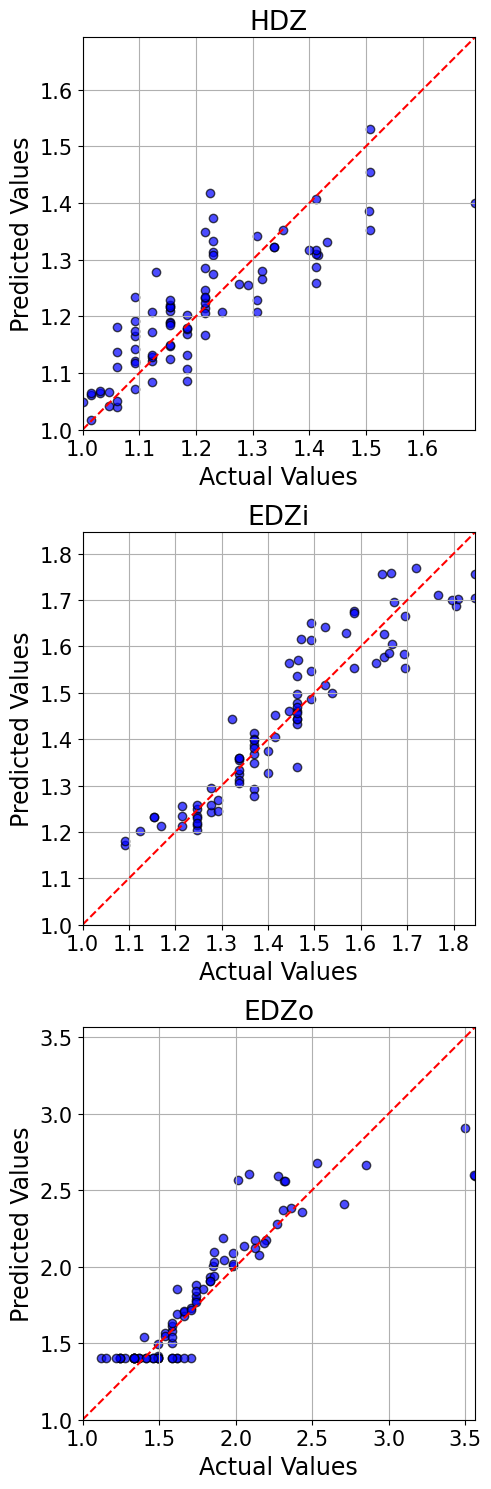

In [86]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']
labels =  ['HDZ', 'EDZi', 'EDZo']
plt.figure(figsize=(5, 15))

for i, target in enumerate(targets):
    plt.subplot(3, 1, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum1[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'{labels[i]}', fontsize=19)
    plt.xlabel('Actual Values', fontsize=17)
    plt.ylabel('Predicted Values', fontsize=17)
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum1[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

    # Adjust x-axis and y-axis tick font sizes
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

plt.tight_layout()
# plt.savefig("E, CI, Sig1, and Sig3.png", format="png", dpi=600, bbox_inches='tight')

plt.show()

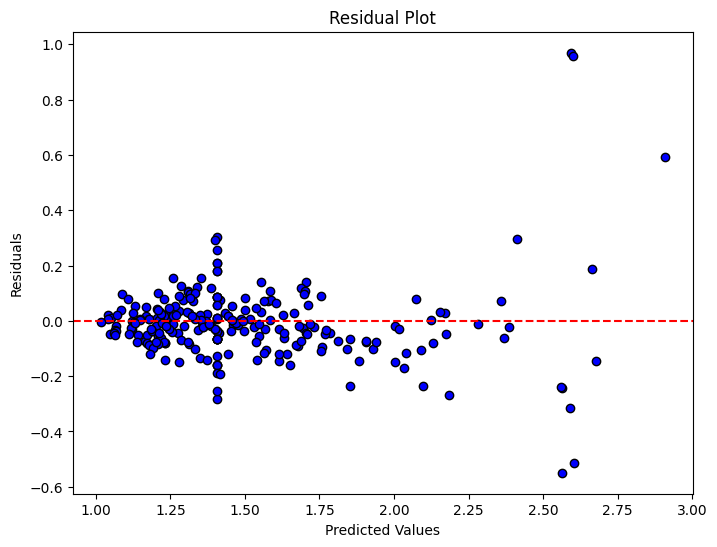

In [87]:
residuals = y_test_EDZ - predictions_optimum1
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum1, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **2. E, T, Sig1, and Sig3**

In [88]:
EDZ_optimum2 = EDZ.drop(['UCS', 'CI','mb peak', 's peak', 'SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum2.columns:
        vif = variance_inflation_factor(EDZ_optimum2.values, EDZ_optimum2.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.262641760856178
VIF for E_40000: 7.136522752517492
VIF for E_75000: 39.52172345437902
VIF for T: 14.075781182603562
VIF for Sig1: 9.932970538467679
VIF for Sig3: 9.600236010271642


In [89]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'T']
stress_components = ['Sig1', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum2, rock_material_properties)
vif_stress_components = calculate_vif(EDZ_optimum2, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.209816
1  E_40000   5.779392
2  E_75000  32.098809
3        T  13.641709

VIF for Stress Components:
  Variable       VIF
0     Sig1  17.41933
1     Sig3  17.41933


In [90]:
#Dropping few columns accordingly
x_train_EDZ_optimum2 = x_train_EDZ.drop(['mb peak', 'UCS', 'CI', 's peak', 'SigZ'], axis=1, inplace=False)
x_test_EDZ_optimum2 = x_test_EDZ.drop(['mb peak', 'UCS', 'CI', 's peak', 'SigZ'], axis=1, inplace=False)

In [91]:
print(x_train_EDZ_optimum2.columns)
print(x_test_EDZ_optimum2.columns)

Index(['E_15000', 'E_40000', 'E_75000', 'T', 'Sig1', 'Sig3'], dtype='object')
Index(['E_15000', 'E_40000', 'E_75000', 'T', 'Sig1', 'Sig3'], dtype='object')


In [92]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum2, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum2 = best_model.predict(x_test_EDZ_optimum2)

# # Evaluate the performance using an appropriate metric
# test_score_optimum2 = r2_score(y_test_EDZ, predictions_optimum2)
# print("R^2 Score on Test Data:", test_score_optimum2)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (6, 4), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.7864045606456388
'''


"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (6, 4), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.7864045606456388\n"

In [93]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(6, 4),
    activation='relu',
    alpha=0.01,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum2, y_train_EDZ)

# Make predictions on the test data
predictions_optimum2 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum2)

# Evaluate the performance using the R^2 score
test_score_optimum2 = r2_score(y_test_EDZ, predictions_optimum2)
print("R^2 Score on Test Data:", test_score_optimum2)

# Calculate and print the mean absolute error
test_score_mae_optimum2 = mean_absolute_error(y_test_EDZ, predictions_optimum2)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum2)

R^2 Score on Test Data: 0.7877396412539078

Mean Absolute Error on Test Data: 0.0789233122612868


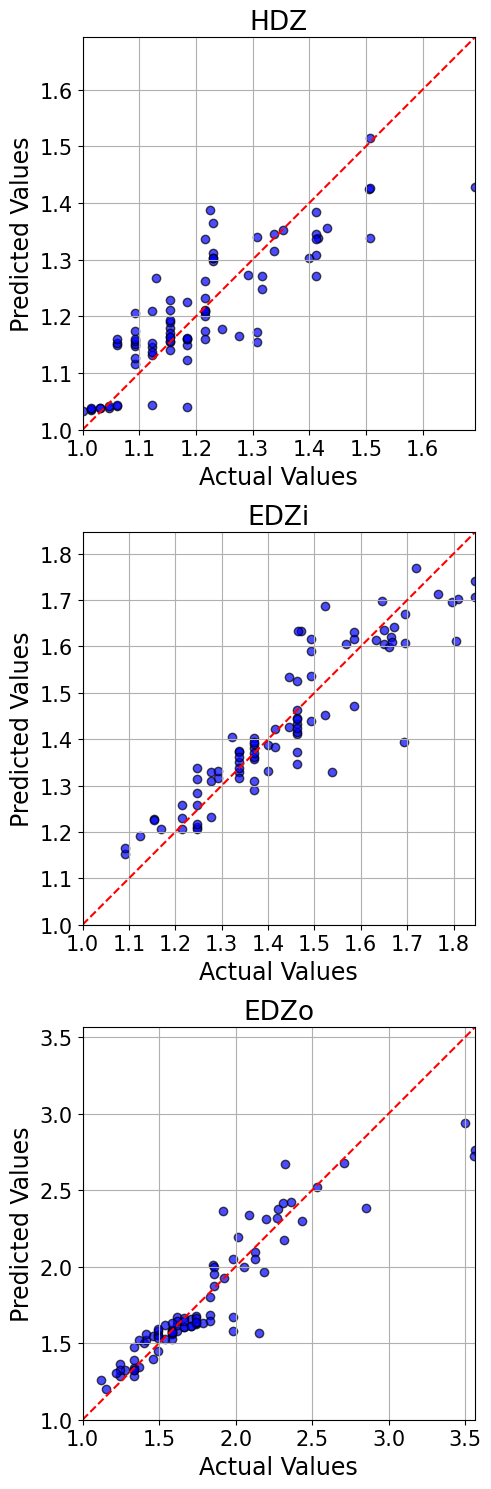

In [94]:
# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']
lebels = ['HDZ', 'EDZi', 'EDZo']

plt.figure(figsize=(5, 15))

for i, target in enumerate(targets):
    plt.subplot(3, 1, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum2[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'{labels[i]}', fontsize=19)
    plt.xlabel('Actual Values', fontsize=17)
    plt.ylabel('Predicted Values', fontsize=17)
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum2[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Adjust x-axis and y-axis tick font sizes
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

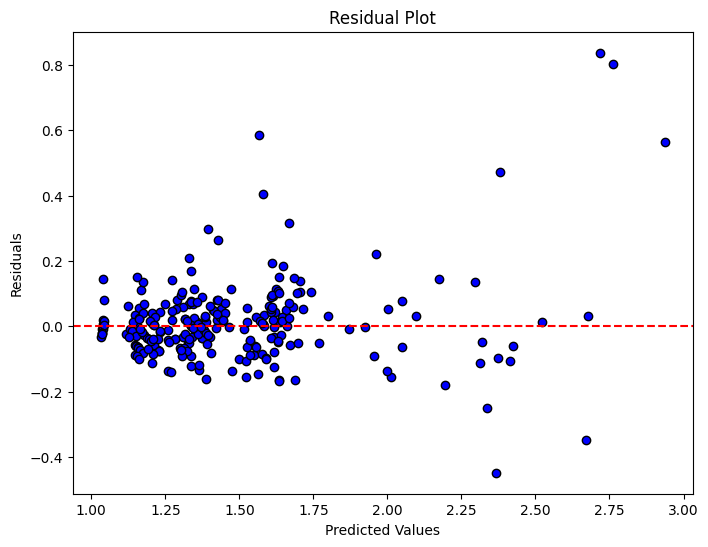

In [95]:
residuals = y_test_EDZ - predictions_optimum2
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum2, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **3. E, CI, T, Sig1, and Sig3**

In [96]:
EDZ_optimum3 = EDZ.drop(['UCS','mb peak', 's peak', 'SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum3.columns:
        vif = variance_inflation_factor(EDZ_optimum3.values, EDZ_optimum3.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.265416749413979
VIF for E_40000: 7.210728025594404
VIF for E_75000: 40.25924249391641
VIF for CI: 26.42825913118711
VIF for T: 30.719817728309483
VIF for Sig1: 10.037324144978534
VIF for Sig3: 10.380188239472178


In [97]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'CI', 'T']
stress_components = ['Sig1', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum3, rock_material_properties)
vif_stress_components = calculate_vif(EDZ_optimum3, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.228390
1  E_40000   6.244696
2  E_75000  34.851882
3       CI  22.465974
4        T  26.719592

VIF for Stress Components:
  Variable       VIF
0     Sig1  17.41933
1     Sig3  17.41933


In [98]:
#Dropping few columns accordingly
x_train_EDZ_optimum3 = x_train_EDZ.drop(['UCS','mb peak', 's peak', 'SigZ'], axis=1, inplace=False)
x_test_EDZ_optimum3 = x_test_EDZ.drop(['UCS','mb peak', 's peak', 'SigZ'], axis=1, inplace=False)

In [99]:
print(x_train_EDZ_optimum3.columns)
print(x_test_EDZ_optimum3.columns)

Index(['E_15000', 'E_40000', 'E_75000', 'CI', 'T', 'Sig1', 'Sig3'], dtype='object')
Index(['E_15000', 'E_40000', 'E_75000', 'CI', 'T', 'Sig1', 'Sig3'], dtype='object')


In [100]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum3, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum3 = best_model.predict(x_test_EDZ_optimum3)

# # Evaluate the performance using an appropriate metric
# test_score_optimum3 = r2_score(y_test_EDZ, predictions_optimum3)
# print("R^2 Score on Test Data:", test_score_optimum3)

'''
est Parameters: {'estimator__activation': 'logistic', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (6, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.8264025392512245
'''

"\nest Parameters: {'estimator__activation': 'logistic', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (6, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.8264025392512245\n"

In [101]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(6, 6),
    activation='logistic',
    alpha=0.0001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum3, y_train_EDZ)

# Make predictions on the test data
predictions_optimum3 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum3)

# Evaluate the performance using the R^2 score
test_score_optimum3 = r2_score(y_test_EDZ, predictions_optimum3)
print("R^2 Score on Test Data:", test_score_optimum3)

# Calculate and print the mean absolute error
test_score_mae_optimum3 = mean_absolute_error(y_test_EDZ, predictions_optimum3)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum3)

R^2 Score on Test Data: 0.8189661170828649

Mean Absolute Error on Test Data: 0.068200113168549


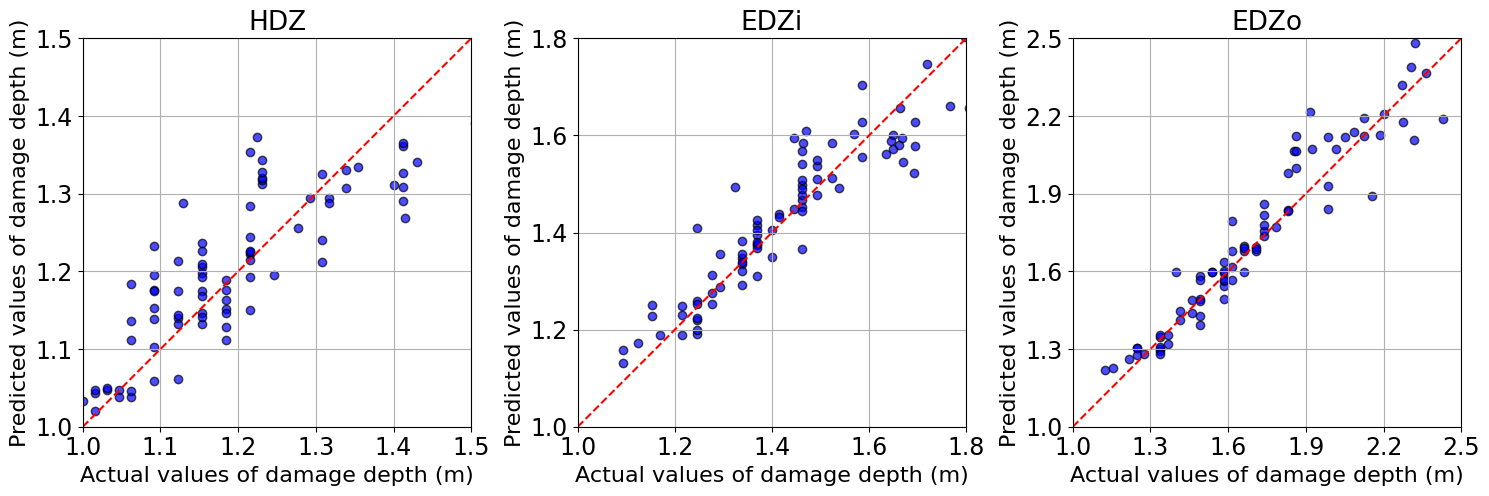

In [102]:
# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']
lebels = ['HDZ', 'EDZi', 'EDZo']

plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum3[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'{labels[i]}', fontsize=19)
    plt.xlabel('Actual values of damage depth (m)', fontsize=16)
    plt.ylabel('Predicted values of damage depth (m)', fontsize=16)
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum3[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    if i==0:
      plt.xlim(1, 1.5)
      plt.ylim(1, 1.5)
      plt.xticks(fontsize=17)
      plt.yticks(fontsize=17)

    if i==1:
      plt.xlim(1, 1.8)
      plt.ylim(1, 1.8)
      plt.xticks(np.arange(1,1.81,0.2),fontsize=17)
      plt.yticks(np.arange(1,1.81,0.2), fontsize=17)

    if i==2:
      plt.xlim(1, 2.5)
      plt.ylim(1, 2.5)
      plt.xticks(np.arange(1,2.51,0.3), fontsize=17)
      plt.yticks(np.arange(1,2.51,0.3),fontsize=17)
    # # Adjust x-axis and y-axis tick font sizes
    # plt.xticks(fontsize=15)
    # plt.yticks(fontsize=15)

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()

plt.savefig("Actual Value vs real value for Medium-Sized MLPS.png", format="png", dpi=600, bbox_inches='tight')


plt.show()

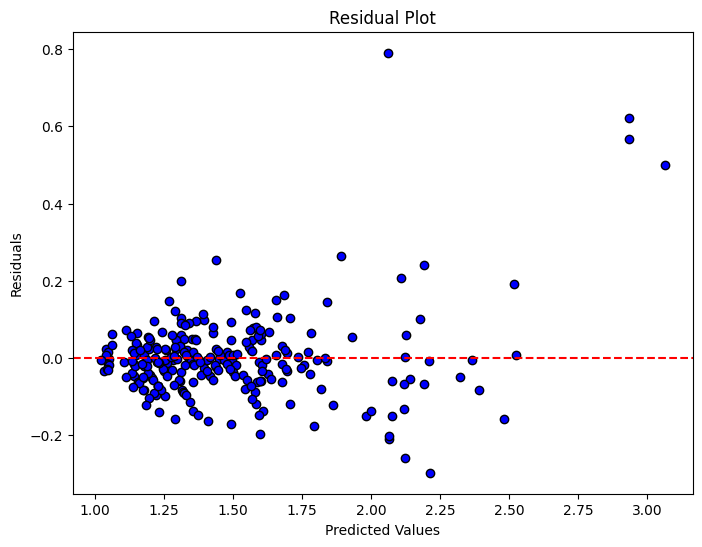

In [103]:
residuals = y_test_EDZ - predictions_optimum3
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum3, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **4. E, CI, UCS, T, Sig1, Sig3 and SigZ**



In [104]:
# But this is exactly similar as Regression Model without Hoek Brown Parameters. So refer to that group of cells

## **5. E, CI, SigZ, and Sig3**

In [105]:
EDZ_optimum5 = EDZ.drop(['UCS', 'mb peak', 'T','s peak', 'Sig1', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum5.columns:
        vif = variance_inflation_factor(EDZ_optimum5.values, EDZ_optimum5.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.1923382124096253
VIF for E_40000: 5.351418808140807
VIF for E_75000: 29.22616756781956
VIF for CI: 12.136659627317558
VIF for Sig3: 13.510893831412888
VIF for SigZ: 14.646644411628401


In [106]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'CI']
stress_components = ['SigZ', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum5, rock_material_properties)
vif_stress_components = calculate_vif(EDZ_optimum5, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.174591
1  E_40000   5.067764
2  E_75000  26.877773
3       CI  11.470021

VIF for Stress Components:
  Variable        VIF
0     SigZ  24.008915
1     Sig3  24.008915


In [107]:
#Dropping few columns accordingly
x_train_EDZ_optimum5 = x_train_EDZ.drop(['UCS', 'mb peak', 'T', 's peak', 'Sig1'], axis=1, inplace=False)
x_test_EDZ_optimum5 = x_test_EDZ.drop(['UCS', 'mb peak', 'T', 's peak', 'Sig1'], axis=1, inplace=False)

In [108]:
print(x_train_EDZ_optimum5.columns)
print(x_test_EDZ_optimum5.columns)

Index(['E_15000', 'E_40000', 'E_75000', 'CI', 'Sig3', 'SigZ'], dtype='object')
Index(['E_15000', 'E_40000', 'E_75000', 'CI', 'Sig3', 'SigZ'], dtype='object')


In [109]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum5, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum5 = best_model.predict(x_test_EDZ_optimum5)

# # Evaluate the performance using an appropriate metric
# test_score_optimum5 = r2_score(y_test_EDZ, predictions_optimum5)
# print("R^2 Score on Test Data:", test_score_optimum5)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (6, 4), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.7817298812500306
'''

"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (6, 4), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.7817298812500306\n"

In [110]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(6, 4),
    activation='relu',
    alpha=0.001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum5, y_train_EDZ)

# Make predictions on the test data
predictions_optimum5 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum5)

# Evaluate the performance using the R^2 score
test_score_optimum5 = r2_score(y_test_EDZ, predictions_optimum5)
print("R^2 Score on Test Data:", test_score_optimum5)

# Calculate and print the mean absolute error
test_score_mae_optimum5 = mean_absolute_error(y_test_EDZ, predictions_optimum5)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum5)

R^2 Score on Test Data: 0.784209134664878

Mean Absolute Error on Test Data: 0.08512911473296679


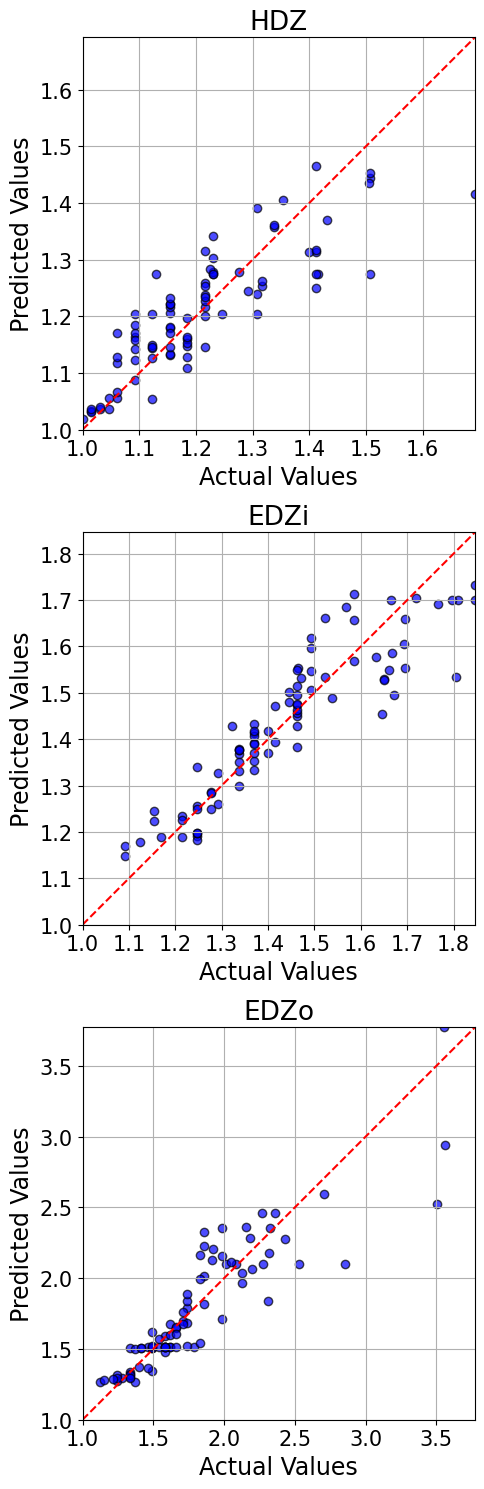

In [111]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']
lebels = ['HDZ', 'EDZi', 'EDZo']

plt.figure(figsize=(5, 15))

for i, target in enumerate(targets):
    plt.subplot(3, 1, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum5[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'{labels[i]}', fontsize=19)
    plt.xlabel('Actual Values', fontsize=17)
    plt.ylabel('Predicted Values', fontsize=17)
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum5[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Adjust x-axis and y-axis tick font sizes
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

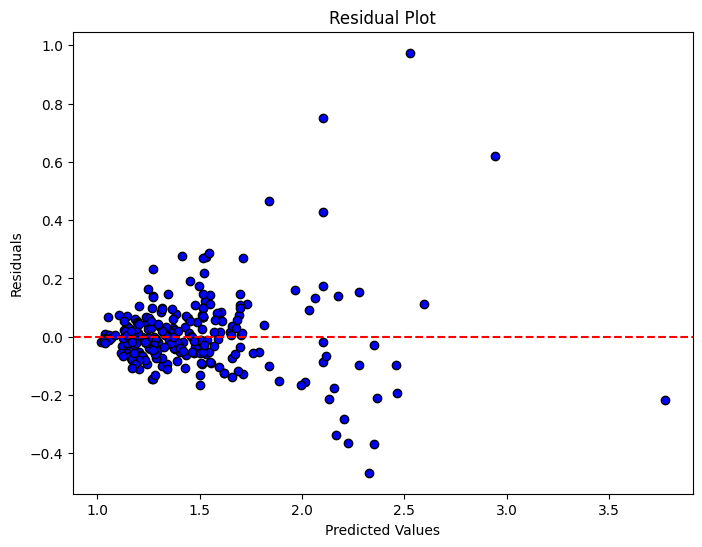

In [112]:
residuals = y_test_EDZ - predictions_optimum5
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum5, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **6. E, T, SigZ, and Sig3**

In [113]:
EDZ_optimum6 = EDZ.drop(['CI', 'UCS','mb peak', 's peak', 'Sig1', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum6.columns:
        vif = variance_inflation_factor(EDZ_optimum6.values, EDZ_optimum6.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.276990075059331
VIF for E_40000: 7.13374426936597
VIF for E_75000: 39.327035666969536
VIF for T: 13.958182094583565
VIF for Sig3: 12.880974897341568
VIF for SigZ: 14.341099084874582


In [114]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'T']
stress_components = ['SigZ', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum6, rock_material_properties)
vif_stress_components = calculate_vif(EDZ_optimum6, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.209816
1  E_40000   5.779392
2  E_75000  32.098809
3        T  13.641709

VIF for Stress Components:
  Variable        VIF
0     SigZ  24.008915
1     Sig3  24.008915


In [115]:
#Dropping few columns accordingly
x_train_EDZ_optimum6 = x_train_EDZ.drop(['mb peak', 'UCS', 'CI', 's peak', 'Sig1'], axis=1, inplace=False)
x_test_EDZ_optimum6 = x_test_EDZ.drop(['mb peak', 'UCS', 'CI', 's peak', 'Sig1'], axis=1, inplace=False)

In [116]:
print(x_train_EDZ_optimum6.columns)
print(x_test_EDZ_optimum6.columns)

Index(['E_15000', 'E_40000', 'E_75000', 'T', 'Sig3', 'SigZ'], dtype='object')
Index(['E_15000', 'E_40000', 'E_75000', 'T', 'Sig3', 'SigZ'], dtype='object')


In [117]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum6, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum6 = best_model.predict(x_test_EDZ_optimum6)

# # Evaluate the performance using an appropriate metric
# test_score_optimum6 = r2_score(y_test_EDZ, predictions_optimum6)
# print("R^2 Score on Test Data:", test_score_optimum6)

'''
Best Parameters: {'estimator__activation': 'logistic', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (6, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.7055194422163087
'''

"\nBest Parameters: {'estimator__activation': 'logistic', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (6, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.7055194422163087\n"

In [118]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(6, 6),
    activation='logistic',
    alpha=0.0001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum6, y_train_EDZ)

# Make predictions on the test data
predictions_optimum6 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum6)

# Evaluate the performance using the R^2 score
test_score_optimum6 = r2_score(y_test_EDZ, predictions_optimum6)
print("R^2 Score on Test Data:", test_score_optimum6)

# Calculate and print the mean absolute error
test_score_mae_optimum6 = mean_absolute_error(y_test_EDZ, predictions_optimum6)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum6)

R^2 Score on Test Data: 0.771712293402769

Mean Absolute Error on Test Data: 0.08728181065818635


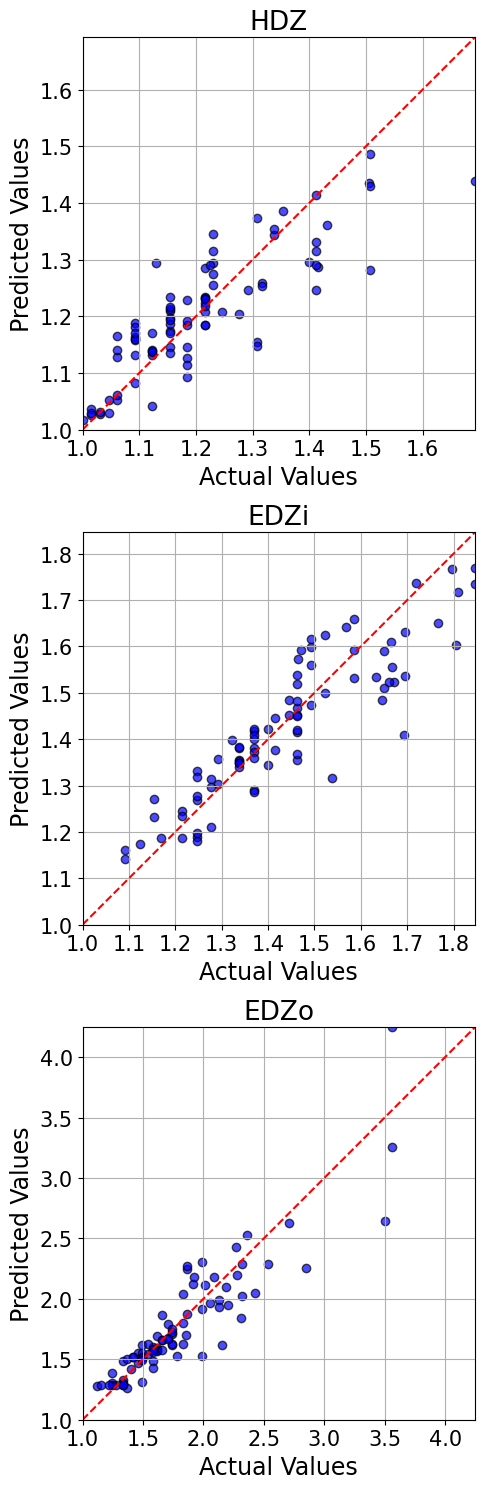

In [119]:
# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']
lebels = ['HDZ', 'EDZi', 'EDZo']

plt.figure(figsize=(5, 15))

for i, target in enumerate(targets):
    plt.subplot(3, 1, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum6[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'{labels[i]}', fontsize=19)
    plt.xlabel('Actual Values', fontsize=17)
    plt.ylabel('Predicted Values', fontsize=17)
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum6[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Adjust x-axis and y-axis tick font sizes
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

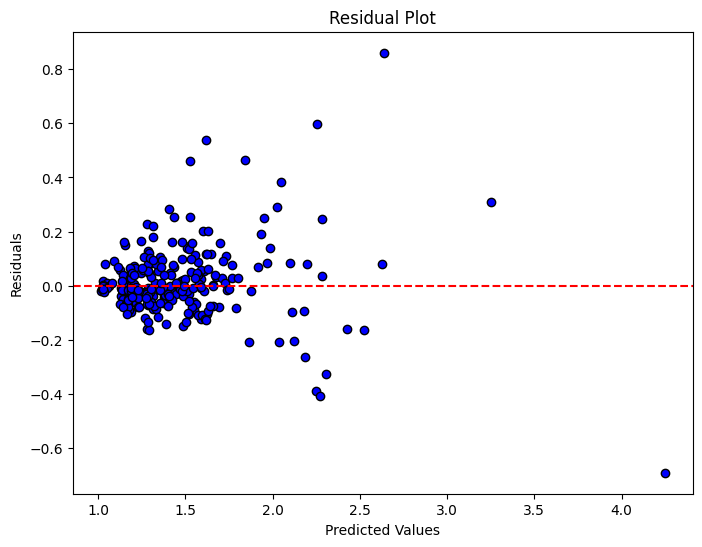

In [120]:
residuals = y_test_EDZ - predictions_optimum6
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum6, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **7. E, CI, T, SigZ, and Sig3**

In [121]:
EDZ_optimum7 = EDZ.drop(['UCS','mb peak', 's peak', 'Sig1', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum7.columns:
        vif = variance_inflation_factor(EDZ_optimum7.values, EDZ_optimum7.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.278226778843078
VIF for E_40000: 7.202864975011722
VIF for E_75000: 40.14659814947009
VIF for CI: 26.849824169045068
VIF for T: 30.879562125605563
VIF for Sig3: 14.186004866655338
VIF for SigZ: 14.72292596050051


In [122]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'CI', 'T']
stress_components = ['SigZ', 'Sig3']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum7, rock_material_properties)
vif_stress_components = calculate_vif(EDZ_optimum7, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
print("\nVIF for Stress Components:")
print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.228390
1  E_40000   6.244696
2  E_75000  34.851882
3       CI  22.465974
4        T  26.719592

VIF for Stress Components:
  Variable        VIF
0     SigZ  24.008915
1     Sig3  24.008915


In [123]:
#Dropping few columns accordingly
x_train_EDZ_optimum7 = x_train_EDZ.drop(['UCS','mb peak', 's peak', 'Sig1'], axis=1, inplace=False)
x_test_EDZ_optimum7 = x_test_EDZ.drop(['UCS','mb peak', 's peak', 'Sig1'], axis=1, inplace=False)

In [124]:
print(x_train_EDZ_optimum7.columns)
print(x_test_EDZ_optimum7.columns)

Index(['E_15000', 'E_40000', 'E_75000', 'CI', 'T', 'Sig3', 'SigZ'], dtype='object')
Index(['E_15000', 'E_40000', 'E_75000', 'CI', 'T', 'Sig3', 'SigZ'], dtype='object')


In [125]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum7, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum7 = best_model.predict(x_test_EDZ_optimum7)

# # Evaluate the performance using an appropriate metric
# test_score_optimum7 = r2_score(y_test_EDZ, predictions_optimum7)
# print("R^2 Score on Test Data:", test_score_optimum7)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (6, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.7205467562248682
'''


"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (6, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.7205467562248682\n"

In [126]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(6, 6),
    activation='relu',
    alpha=0.01,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum7, y_train_EDZ)

# Make predictions on the test data
predictions_optimum7 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum7)

# Evaluate the performance using the R^2 score
test_score_optimum7 = r2_score(y_test_EDZ, predictions_optimum7)
print("R^2 Score on Test Data:", test_score_optimum7)

# Calculate and print the mean absolute error
test_score_mae_optimum7 = mean_absolute_error(y_test_EDZ, predictions_optimum7)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum7)

R^2 Score on Test Data: 0.7665649150850902

Mean Absolute Error on Test Data: 0.08550102222897708


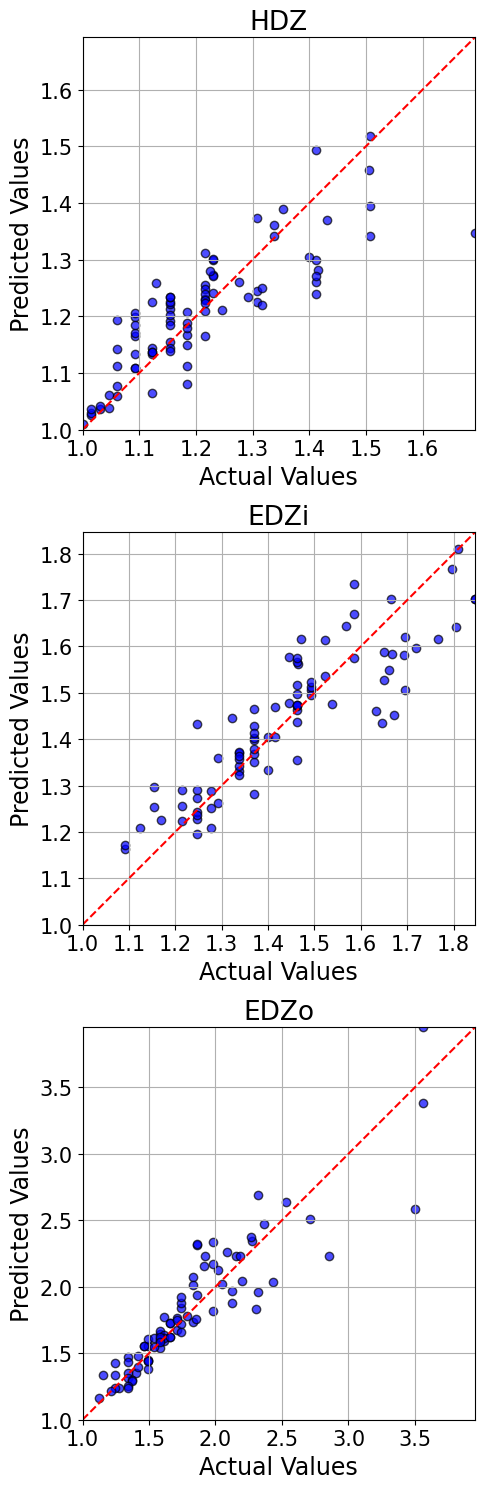

In [127]:
# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']
lebels = ['HDZ', 'EDZi', 'EDZo']

plt.figure(figsize=(5, 15))

for i, target in enumerate(targets):
    plt.subplot(3, 1, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum7[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'{labels[i]}', fontsize=19)
    plt.xlabel('Actual Values', fontsize=17)
    plt.ylabel('Predicted Values', fontsize=17)
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum7[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Adjust x-axis and y-axis tick font sizes
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

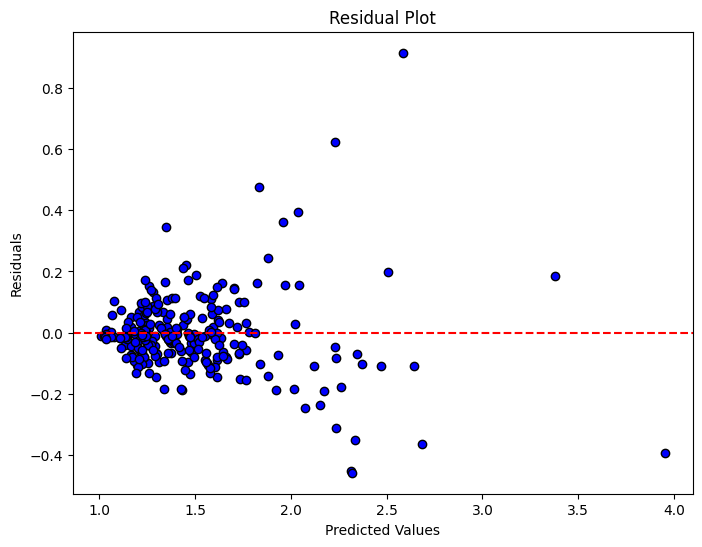

In [128]:
residuals = y_test_EDZ - predictions_optimum7
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum7, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **Plotting $R^2$ & $MAE$  for Different Medium-Sized Optimum MLPS**

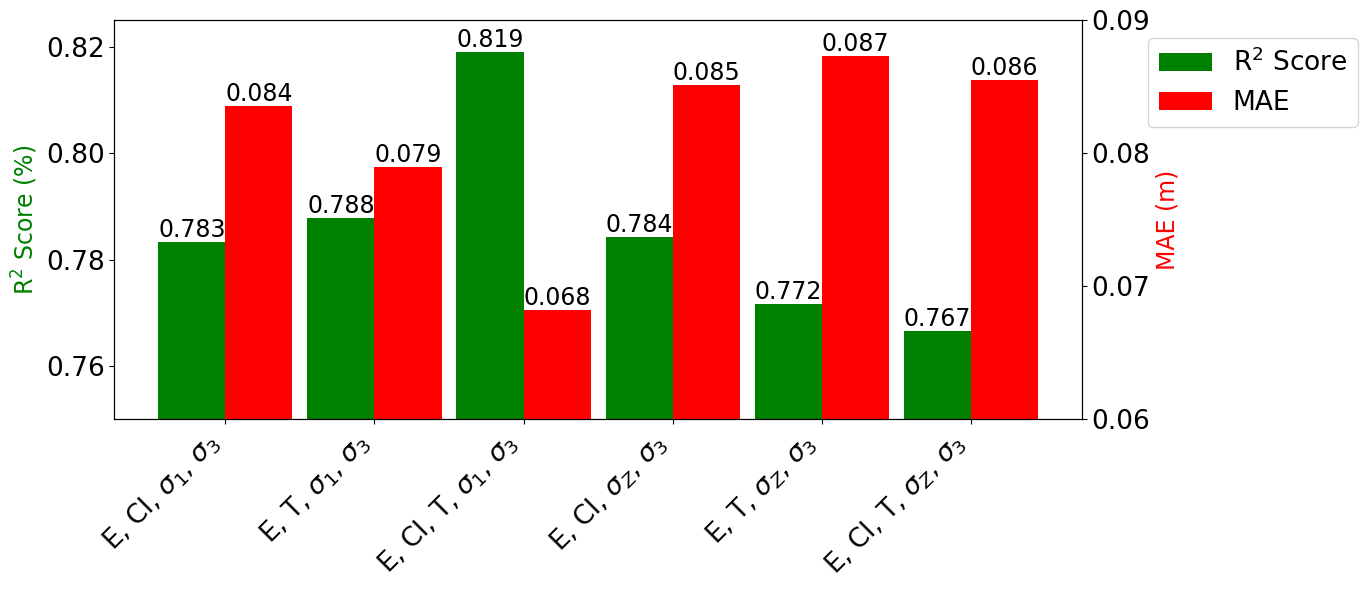

In [129]:

# Assuming you already have the MAE and R-squared values
mae_values = (test_score_mae_optimum1, test_score_mae_optimum2,
              test_score_mae_optimum3, test_score_mae_optimum5,
              test_score_mae_optimum6, test_score_mae_optimum7)

r_squared_values = (test_score_optimum1, test_score_optimum2,
                    test_score_optimum3, test_score_optimum5,
                    test_score_optimum6, test_score_optimum7)

# X-axis values
x_eval = np.array([1, 2, 3, 4, 5, 6])
my_xticks = ['E, CI, $\sigma_1$, $\sigma_3$', 'E, T, $\sigma_1$, $\sigma_3$',
             'E, CI, T, $\sigma_1$, $\sigma_3$', 'E, CI, $\sigma_Z$, $\sigma_3$',
             'E, T, $\sigma_Z$, $\sigma_3$', 'E, CI, T, $\sigma_Z$, $\sigma_3$']

# Set the width of the bars
bar_width = 0.45

# Create subplots with 2 rows and 1 column
fig, axs1 = plt.subplots(figsize=(12, 6))

# Calculate positions for the bars
bar_positions_r_squared = x_eval - bar_width / 2
bar_positions_mae = x_eval + bar_width / 2

# Plotting R-squared values on the first y-axis
bars_r_squared = axs1.bar(bar_positions_r_squared, r_squared_values, width=bar_width, color='green', label='R$^2$ Score')
axs1.set_xticks(x_eval)
axs1.set_xticklabels(my_xticks, rotation=45, ha='right', fontsize=19)
axs1.set_ylabel('R$^2$ Score (%)', color='green', fontsize=17)
axs1.set_yticks(np.arange(0.76, 0.83, 0.02))
axs1.tick_params(axis='y', labelsize=19)
axs1.set_ylim(0.75, 0.825)

# Displaying numeric values on top of the bars
for bar, value in zip(bars_r_squared, r_squared_values):
    axs1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.3f}',
              ha='center', va='bottom', fontsize=17)

# Create a second y-axis for MAE values
axs2 = axs1.twinx()
bars_mae = axs2.bar(bar_positions_mae, mae_values, width=bar_width, color='red', label='MAE')
axs2.set_ylabel('MAE (m)', color='red', fontsize=17)
axs2.set_yticks(np.arange(0.05, 0.091, 0.01))
axs2.tick_params(axis='y', labelsize=19)
axs2.set_ylim(0.06, 0.09)

# Displaying numeric values on top of the bars for the second y-axis
for bar, value in zip(bars_mae, mae_values):
    axs2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.3f}',
              ha='center', va='bottom', fontsize=17)

# Adjust layout
plt.tight_layout()

# Show the legend for both y-axes
fig.legend(loc='upper left', bbox_to_anchor=(0.95, 0.95), fontsize=19)

# Save the figure before displaying or showing
plt.savefig("Comparison of R-squared & MAE-medium sized MLP Models.png", format="png", dpi=600, bbox_inches='tight')

plt.show()


# **Small-Sized Optimum MLP Models based on VIFs**

## **8. E, CI, and Sig1**

In [130]:
EDZ_optimum8 = EDZ.drop(['UCS', 'T', 'mb peak', 's peak', 'Sig3', 'SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum8.columns:
        vif = variance_inflation_factor(EDZ_optimum8.values, EDZ_optimum8.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.180678243495815
VIF for E_40000: 5.317949146763389
VIF for E_75000: 28.561155430503707
VIF for CI: 11.544240376461115
VIF for Sig1: 2.225744493704234


In [131]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'CI']
stress_components = ['Sig1']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum8, rock_material_properties)
# vif_stress_components = calculate_vif(EDZ_optimum8, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Stress Components:")
# print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.174591
1  E_40000   5.067764
2  E_75000  26.877773
3       CI  11.470021


In [132]:
#Dropping few columns accordingly
x_train_EDZ_optimum8 = x_train_EDZ.drop(['UCS', 'mb peak', 'T', 's peak', 'SigZ', 'Sig3'], axis=1, inplace=False)
x_test_EDZ_optimum8 = x_test_EDZ.drop(['UCS', 'mb peak', 'T', 's peak', 'SigZ', 'Sig3'], axis=1, inplace=False)

In [133]:
print(x_train_EDZ_optimum8.columns)
print(x_test_EDZ_optimum8.columns)

Index(['E_15000', 'E_40000', 'E_75000', 'CI', 'Sig1'], dtype='object')
Index(['E_15000', 'E_40000', 'E_75000', 'CI', 'Sig1'], dtype='object')


In [134]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum8, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum8 = best_model.predict(x_test_EDZ_optimum8)

# # Evaluate the performance using an appropriate metric
# test_score_optimum8 = r2_score(y_test_EDZ, predictions_optimum8)
# print("R^2 Score on Test Data:", test_score_optimum8)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (5, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.8333696964531505
'''


"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (5, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.8333696964531505\n"

In [135]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(5, 6),
    activation='relu',
    alpha=0.0001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum8, y_train_EDZ)

# Make predictions on the test data
predictions_optimum8 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum8)

# Evaluate the performance using the R^2 score
test_score_optimum8 = r2_score(y_test_EDZ, predictions_optimum8)
print("R^2 Score on Test Data:", test_score_optimum8)

# Calculate and print the mean absolute error
test_score_mae_optimum8 = mean_absolute_error(y_test_EDZ, predictions_optimum8)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum8)

R^2 Score on Test Data: 0.8301585221532838

Mean Absolute Error on Test Data: 0.06832674997816472


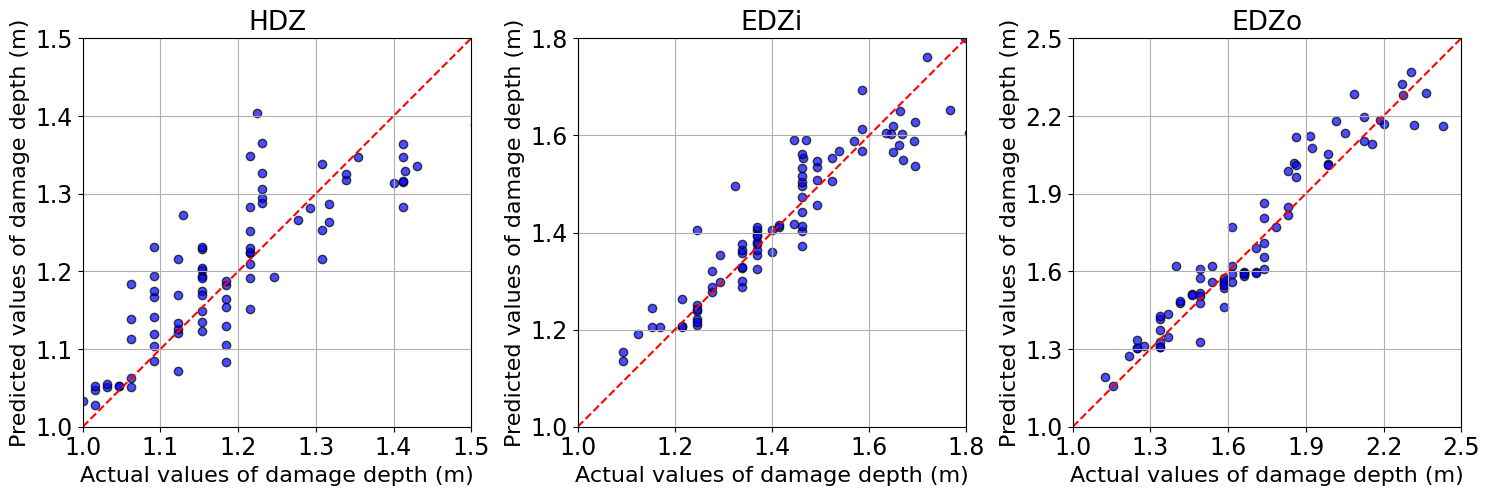

In [136]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']
labels =  ['HDZ', 'EDZi', 'EDZo']
plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum8[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'{labels[i]}', fontsize=19)
    plt.xlabel('Actual values of damage depth (m)', fontsize=16)
    plt.ylabel('Predicted values of damage depth (m)', fontsize=16)
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum8[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

    if i==0:
      plt.xlim(1, 1.5)
      plt.ylim(1, 1.5)
      plt.xticks(fontsize=17)
      plt.yticks(fontsize=17)

    if i==1:
      plt.xlim(1, 1.8)
      plt.ylim(1, 1.8)
      plt.xticks(np.arange(1,1.81,0.2),fontsize=17)
      plt.yticks(np.arange(1,1.81,0.2), fontsize=17)

    if i==2:
      plt.xlim(1, 2.5)
      plt.ylim(1, 2.5)
      plt.xticks(np.arange(1,2.51,0.3), fontsize=17)
      plt.yticks(np.arange(1,2.51,0.3),fontsize=17)
    # # Adjust x-axis and y-axis tick font sizes
    # plt.xticks(fontsize=15)
    # plt.yticks(fontsize=15)

plt.tight_layout()
# plt.savefig("E, CI, Sig1, and Sig3.png", format="png", dpi=600, bbox_inches='tight')
plt.savefig("Actual Value vs real value for Small-Sized MLPS.png", format="png", dpi=600, bbox_inches='tight')

plt.show()

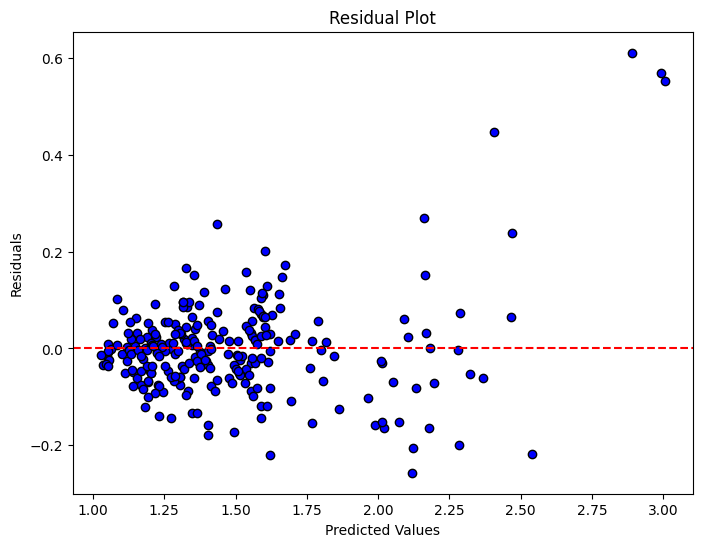

In [137]:
residuals = y_test_EDZ - predictions_optimum8
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum8, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **9. E, CI, and SigZ**

In [138]:
EDZ_optimum9 = EDZ.drop(['UCS', 'T', 'mb peak', 's peak', 'Sig3', 'Sig1', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum9.columns:
        vif = variance_inflation_factor(EDZ_optimum9.values, EDZ_optimum9.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.177030934159097
VIF for E_40000: 5.338757502130072
VIF for E_75000: 28.671111667233784
VIF for CI: 11.569666778792344
VIF for SigZ: 2.4172294213335666


In [139]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'CI']
stress_components = ['SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum9, rock_material_properties)
# vif_stress_components = calculate_vif(EDZ_optimum8, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Stress Components:")
# print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.174591
1  E_40000   5.067764
2  E_75000  26.877773
3       CI  11.470021


In [140]:
#Dropping few columns accordingly
x_train_EDZ_optimum9 = x_train_EDZ.drop(['UCS', 'mb peak', 'T', 's peak', 'Sig1', 'Sig3'], axis=1, inplace=False)
x_test_EDZ_optimum9 = x_test_EDZ.drop(['UCS', 'mb peak', 'T', 's peak', 'Sig1', 'Sig3'], axis=1, inplace=False)

In [141]:
print(x_train_EDZ_optimum9.columns)
print(x_test_EDZ_optimum9.columns)

Index(['E_15000', 'E_40000', 'E_75000', 'CI', 'SigZ'], dtype='object')
Index(['E_15000', 'E_40000', 'E_75000', 'CI', 'SigZ'], dtype='object')


In [142]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum9, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum9 = best_model.predict(x_test_EDZ_optimum9)

# # Evaluate the performance using an appropriate metric
# test_score_optimum9 = r2_score(y_test_EDZ, predictions_optimum9)
# print("R^2 Score on Test Data:", test_score_optimum1)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (6, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.7544561678089178
'''


"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (6, 6), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.7544561678089178\n"

In [143]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(6, 6),
    activation='relu',
    alpha=0.0001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum9, y_train_EDZ)

# Make predictions on the test data
predictions_optimum9 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum9)

# Evaluate the performance using the R^2 score
test_score_optimum9 = r2_score(y_test_EDZ, predictions_optimum9)
print("R^2 Score on Test Data:", test_score_optimum9)

# Calculate and print the mean absolute error
test_score_mae_optimum9 = mean_absolute_error(y_test_EDZ, predictions_optimum9)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum9)

R^2 Score on Test Data: 0.6919380773721974

Mean Absolute Error on Test Data: 0.099244646243134


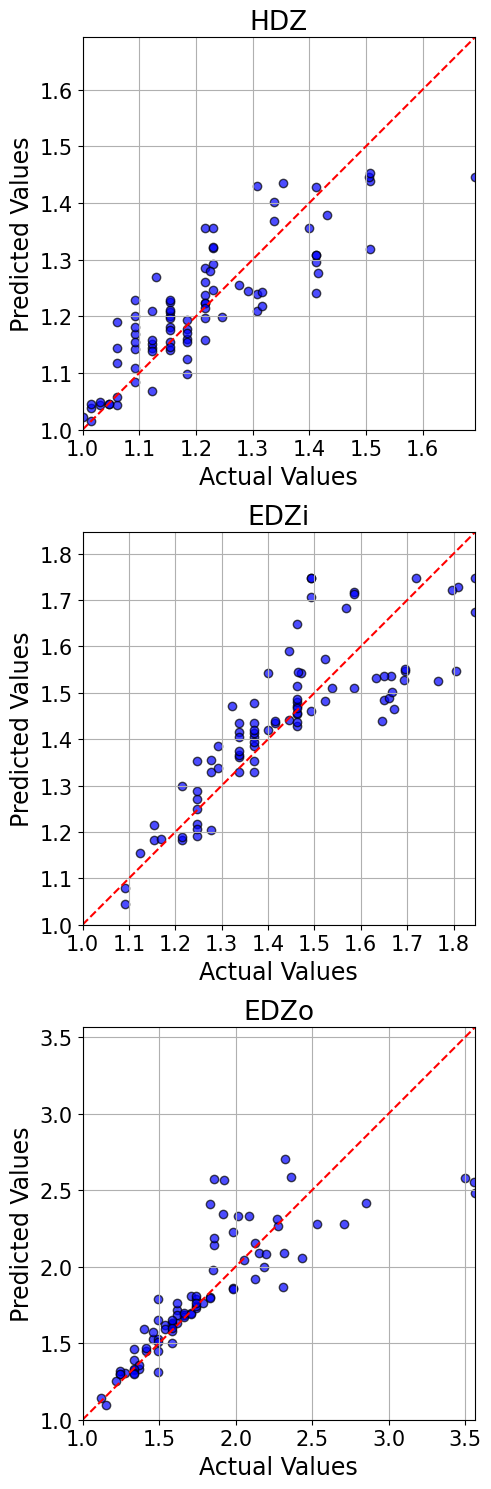

In [144]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']
labels =  ['HDZ', 'EDZi', 'EDZo']
plt.figure(figsize=(5, 15))

for i, target in enumerate(targets):
    plt.subplot(3, 1, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum9[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'{labels[i]}', fontsize=19)
    plt.xlabel('Actual Values', fontsize=17)
    plt.ylabel('Predicted Values', fontsize=17)
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum9[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

    # Adjust x-axis and y-axis tick font sizes
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

plt.tight_layout()
# plt.savefig("E, CI, Sig1, and Sig3.png", format="png", dpi=600, bbox_inches='tight')

plt.show()

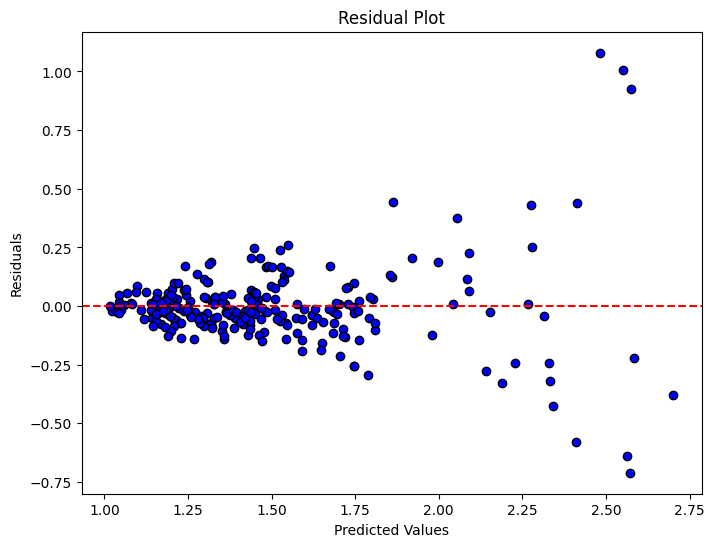

In [145]:
residuals = y_test_EDZ - predictions_optimum9
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum9, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **10. E, T, and Sig1**

In [146]:
EDZ_optimum10 = EDZ.drop(['UCS', 'CI', 'mb peak', 's peak', 'Sig3', 'SigZ', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum10.columns:
        vif = variance_inflation_factor(EDZ_optimum10.values, EDZ_optimum10.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.2469466266840297
VIF for E_40000: 6.8836346738567835
VIF for E_75000: 39.375968244276685
VIF for T: 14.055182690310279
VIF for Sig1: 2.2784624473965773


In [147]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'T']
stress_components = ['Sig1']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum10, rock_material_properties)
# vif_stress_components = calculate_vif(EDZ_optimum8, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Stress Components:")
# print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.209816
1  E_40000   5.779392
2  E_75000  32.098809
3        T  13.641709


In [148]:
#Dropping few columns accordingly
x_train_EDZ_optimum10 = x_train_EDZ.drop(['UCS', 'mb peak', 'CI', 's peak', 'SigZ', 'Sig3'], axis=1, inplace=False)
x_test_EDZ_optimum10 = x_test_EDZ.drop(['UCS', 'mb peak', 'CI', 's peak', 'SigZ', 'Sig3'], axis=1, inplace=False)

In [149]:
print(x_train_EDZ_optimum10.columns)
print(x_test_EDZ_optimum10.columns)

Index(['E_15000', 'E_40000', 'E_75000', 'T', 'Sig1'], dtype='object')
Index(['E_15000', 'E_40000', 'E_75000', 'T', 'Sig1'], dtype='object')


In [150]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum10, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum10 = best_model.predict(x_test_EDZ_optimum10)

# # Evaluate the performance using an appropriate metric
# test_score_optimum10 = r2_score(y_test_EDZ, predictions_optimum10)
# print("R^2 Score on Test Data:", test_score_optimum10)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (6, 4), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.7631924063267089
'''


"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (6, 4), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.7631924063267089\n"

In [151]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(6, 4),
    activation='relu',
    alpha=0.001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum10, y_train_EDZ)

# Make predictions on the test data
predictions_optimum10 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum10)

# Evaluate the performance using the R^2 score
test_score_optimum10 = r2_score(y_test_EDZ, predictions_optimum10)
print("R^2 Score on Test Data:", test_score_optimum10)

# Calculate and print the mean absolute error
test_score_mae_optimum10 = mean_absolute_error(y_test_EDZ, predictions_optimum10)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum10)

R^2 Score on Test Data: 0.779285145384898

Mean Absolute Error on Test Data: 0.08174963453265349


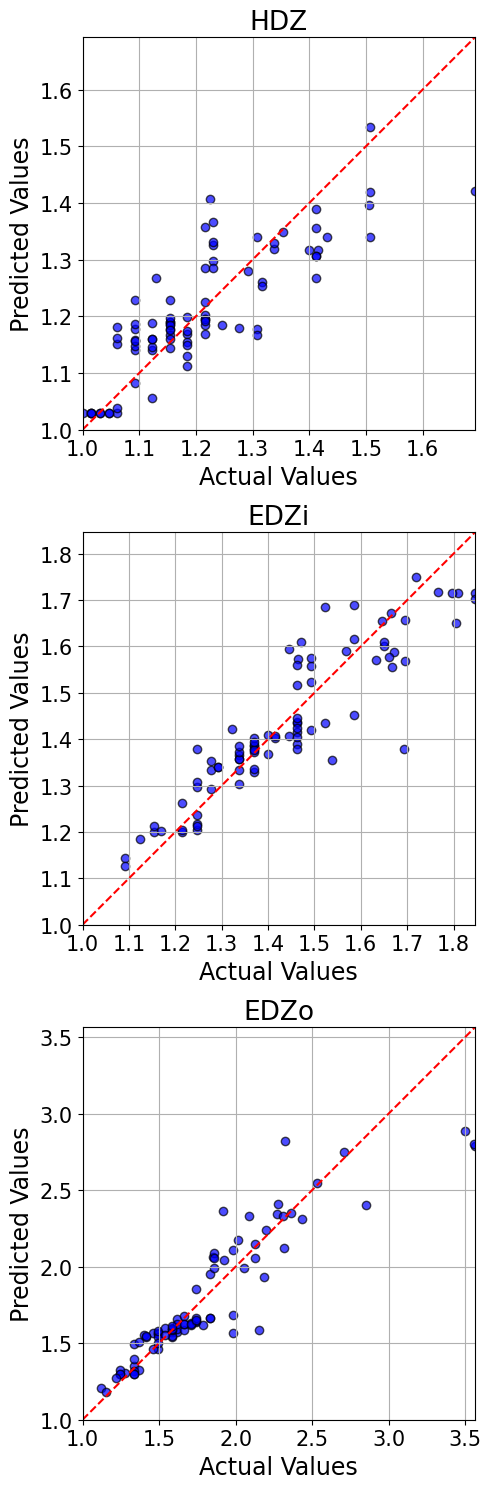

In [152]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']
labels =  ['HDZ', 'EDZi', 'EDZo']
plt.figure(figsize=(5, 15))

for i, target in enumerate(targets):
    plt.subplot(3, 1, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum10[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'{labels[i]}', fontsize=19)
    plt.xlabel('Actual Values', fontsize=17)
    plt.ylabel('Predicted Values', fontsize=17)
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum10[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

    # Adjust x-axis and y-axis tick font sizes
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

plt.tight_layout()
# plt.savefig("E, CI, Sig1, and Sig3.png", format="png", dpi=600, bbox_inches='tight')

plt.show()

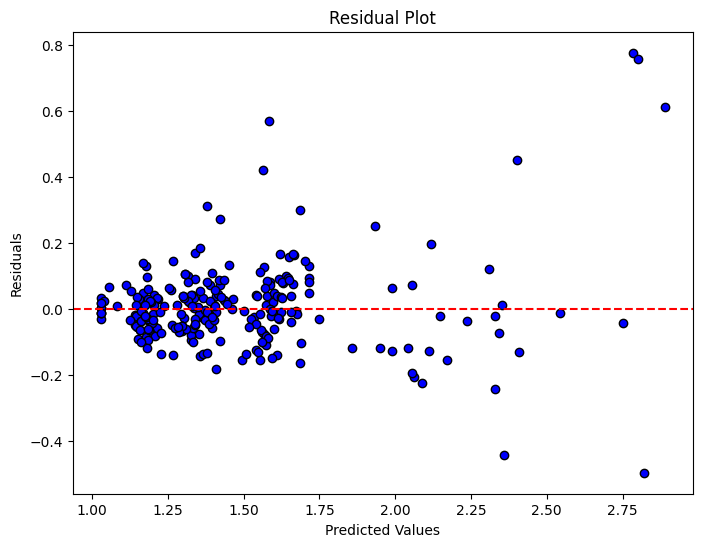

In [153]:
residuals = y_test_EDZ - predictions_optimum10
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum10, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **11. E, T, and SigZ**

In [154]:
EDZ_optimum11 = EDZ.drop(['UCS', 'CI', 'mb peak', 's peak', 'Sig3', 'Sig1', 'HDZ/a', 'EDZi/a', 'EDZo/a'], axis=1, inplace=False)
for column in EDZ_optimum11.columns:
        vif = variance_inflation_factor(EDZ_optimum11.values, EDZ_optimum11.columns.get_loc(column))
        print(f"VIF for {column}: {vif}")

VIF for E_15000: 1.2349655554348302
VIF for E_40000: 6.873203243419554
VIF for E_75000: 39.247693493723595
VIF for T: 13.95680098319939
VIF for SigZ: 2.4517621722602665


In [155]:
rock_material_properties = ['E_15000', 'E_40000', 'E_75000', 'T']
stress_components = ['SigZ']
# Calculate VIF and print for each group
vif_rock_material = calculate_vif(EDZ_optimum10, rock_material_properties)
# vif_stress_components = calculate_vif(EDZ_optimum8, stress_components)
print("VIF for Rock Material Properties:")
print(vif_rock_material)
# print("\nVIF for Stress Components:")
# print(vif_stress_components)

VIF for Rock Material Properties:
  Variable        VIF
0  E_15000   1.209816
1  E_40000   5.779392
2  E_75000  32.098809
3        T  13.641709


In [156]:
#Dropping few columns accordingly
x_train_EDZ_optimum11 = x_train_EDZ.drop(['UCS', 'mb peak', 'CI', 's peak', 'Sig1', 'Sig3'], axis=1, inplace=False)
x_test_EDZ_optimum11 = x_test_EDZ.drop(['UCS', 'mb peak', 'CI', 's peak', 'Sig1', 'Sig3'], axis=1, inplace=False)

In [157]:
print(x_train_EDZ_optimum11.columns)
print(x_test_EDZ_optimum11.columns)

Index(['E_15000', 'E_40000', 'E_75000', 'T', 'SigZ'], dtype='object')
Index(['E_15000', 'E_40000', 'E_75000', 'T', 'SigZ'], dtype='object')


In [158]:
# # Create an MLP regression model
# mlp_regressor = MLPRegressor(random_state=7)

# # Wrap the MLP model with MultiOutputRegressor
# mlp_multioutput_regressor = MultiOutputRegressor(mlp_regressor)

# # Define the parameter grid
# layers = [(i, j) for i in range(1, 7) for j in range(1, 7)]
# params_grid = {
#     'estimator__hidden_layer_sizes': layers,
#     'estimator__activation': ['logistic', 'relu'],
#     'estimator__alpha': [1e-4, 1e-3, 1e-2, 0.1],
#     'estimator__solver': ['lbfgs', 'sgd', 'adam'],
#     'estimator__learning_rate': ['constant', 'adaptive']
# }

# # Define the scoring metric (use 'r2' or another   metric for regression)
# scorer = make_scorer(r2_score)

# # Create the GridSearchCV object
# gridsearch_MLPReg = GridSearchCV(
#     mlp_multioutput_regressor,
#     params_grid,
#     n_jobs=-1,
#     cv=5,
#     scoring=scorer
# )

# # Fit the grid search to the training data
# gridsearch_MLPReg.fit(x_train_EDZ_optimum11, y_train_EDZ)

# # Get the best parameters and the best model
# best_params = gridsearch_MLPReg.best_params_
# best_model = gridsearch_MLPReg.best_estimator_

# print("Best Parameters:", best_params)

# # Make predictions on the test data using the best model
# predictions_optimum11 = best_model.predict(x_test_EDZ_optimum11)

# # Evaluate the performance using an appropriate metric
# test_score_optimum11 = r2_score(y_test_EDZ, predictions_optimum11)
# print("R^2 Score on Test Data:", test_score_optimum11)

'''
Best Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (6, 4), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}
R^2 Score on Test Data: 0.6743185315446407
'''


"\nBest Parameters: {'estimator__activation': 'relu', 'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (6, 4), 'estimator__learning_rate': 'constant', 'estimator__solver': 'lbfgs'}\nR^2 Score on Test Data: 0.6743185315446407\n"

In [159]:
#BEST MLP Regressor
# Create an MLP regression model with the best parameters
best_mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(5, 5),
    activation='relu',
    alpha=0.001,
    solver='lbfgs',
    learning_rate='constant',
    random_state=7
)

# Wrap the MLP model with MultiOutputRegressor
best_mlp_multioutput_regressor = MultiOutputRegressor(best_mlp_regressor)

# Fit the model to the training data
best_mlp_multioutput_regressor.fit(x_train_EDZ_optimum11, y_train_EDZ)

# Make predictions on the test data
predictions_optimum11 = best_mlp_multioutput_regressor.predict(x_test_EDZ_optimum11)

# Evaluate the performance using the R^2 score
test_score_optimum11 = r2_score(y_test_EDZ, predictions_optimum11)
print("R^2 Score on Test Data:", test_score_optimum11)

# Calculate and print the mean absolute error
test_score_mae_optimum11 = mean_absolute_error(y_test_EDZ, predictions_optimum11)
print("\nMean Absolute Error on Test Data:", test_score_mae_optimum11)

R^2 Score on Test Data: 0.5774409042885332

Mean Absolute Error on Test Data: 0.11973989687119234


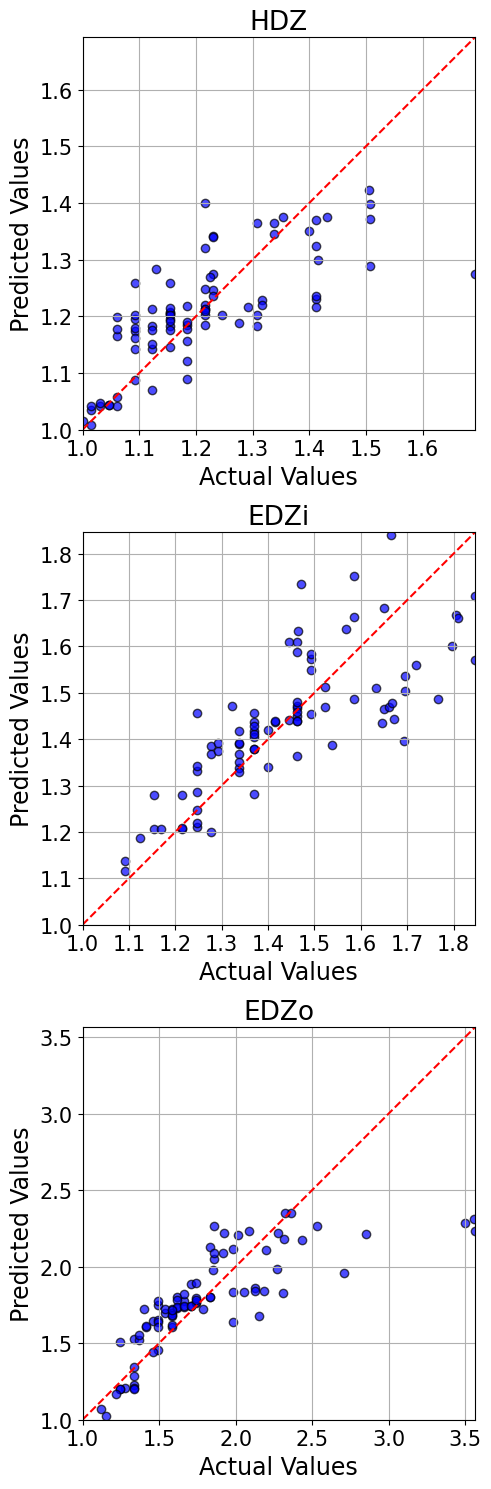

In [160]:

# Scatter plots for each target variable
targets = ['HDZ/a', 'EDZi/a', 'EDZo/a']
labels =  ['HDZ', 'EDZi', 'EDZo']
plt.figure(figsize=(5, 15))

for i, target in enumerate(targets):
    plt.subplot(3, 1, i+1)
    plt.scatter(y_test_EDZ[target], predictions_optimum11[:, i], color='blue', edgecolors='k', alpha=0.7)
    plt.title(f'{labels[i]}', fontsize=19)
    plt.xlabel('Actual Values', fontsize=17)
    plt.ylabel('Predicted Values', fontsize=17)
    plt.grid(True)

    # Set limits based on the maximum values of actual and predicted data
    max_limit = max(y_test_EDZ[target].max(), predictions_optimum11[:, i].max())
    plt.xlim(1, max_limit)
    plt.ylim(1, max_limit)

    # Plot x=y line
    plt.plot([1, max_limit], [1, max_limit], color='red', linestyle='--')

    # Ensure equal axes
    plt.gca().set_aspect('equal', adjustable='box')

    # Adjust x-axis and y-axis tick font sizes
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

plt.tight_layout()
# plt.savefig("E, CI, Sig1, and Sig3.png", format="png", dpi=600, bbox_inches='tight')

plt.show()

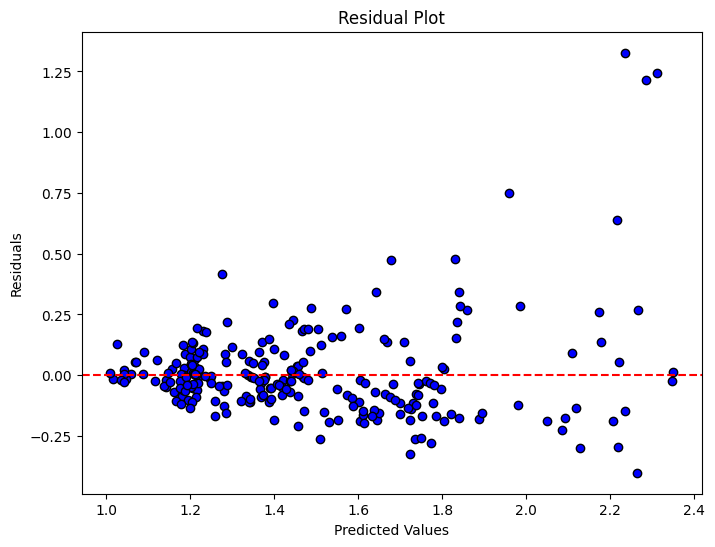

In [161]:
residuals = y_test_EDZ - predictions_optimum11
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum11, residuals, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## **Plotting $R^2$ & $MAE$  for Different Small-Sized Optimum MLPS**

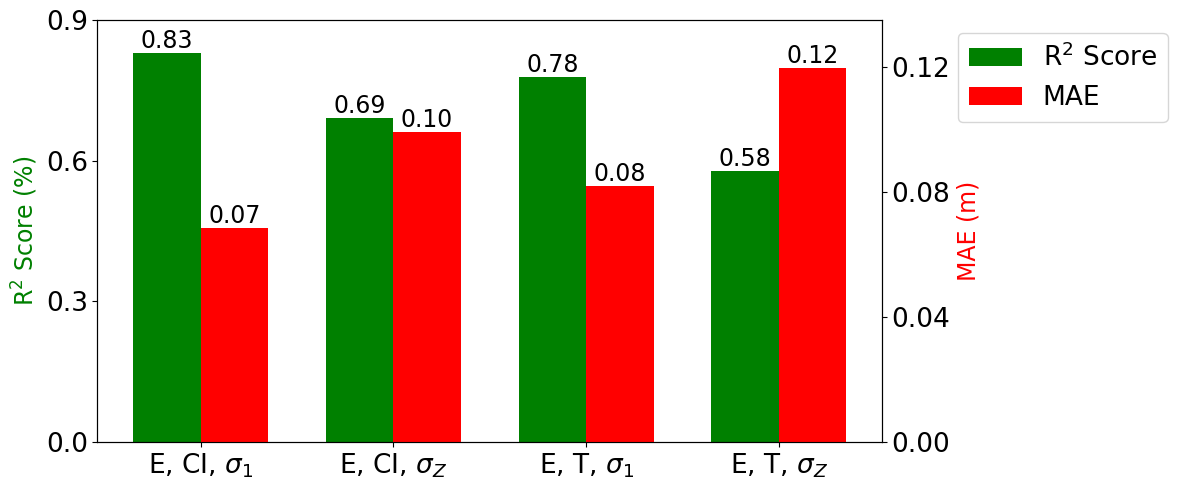

In [162]:

# Assuming you already have the MAE and R-squared values
mae_values = (test_score_mae_optimum8, test_score_mae_optimum9,
              test_score_mae_optimum10, test_score_mae_optimum11)

r_squared_values = (test_score_optimum8, test_score_optimum9,
                    test_score_optimum10, test_score_optimum11)

# X-axis values
x_eval = np.array([1, 2, 3, 4])
my_xticks = ['E, CI, $\sigma_1$', 'E, CI, $\sigma_Z$', 'E, T, $\sigma_1$', 'E, T, $\sigma_Z$']

# Set the width of the bars
bar_width = 0.35

# Create subplots with 2 rows and 1 column
fig, axs1 = plt.subplots(figsize=(10, 5))

# Calculate positions for the bars
bar_positions_r_squared = x_eval - bar_width / 2
bar_positions_mae = x_eval + bar_width / 2

# Plotting R-squared values on the first y-axis
bars_r_squared = axs1.bar(bar_positions_r_squared, r_squared_values, width=bar_width, color='green', label='R$^2$ Score')
axs1.set_xticks(x_eval)
axs1.set_xticklabels(my_xticks, fontsize=19)
axs1.set_ylabel('R$^2$ Score (%)', color='green', fontsize=17)
axs1.set_yticks(np.arange(0, 0.91, 0.3))
axs1.tick_params(axis='y', labelsize=19)
axs1.set_ylim(0, 0.9)

# Displaying numeric values on top of the bars
for bar, value in zip(bars_r_squared, r_squared_values):
    axs1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}',
              ha='center', va='bottom', fontsize=17)

# Create a second y-axis for MAE values
axs2 = axs1.twinx()
bars_mae = axs2.bar(bar_positions_mae, mae_values, width=bar_width, color='red', label='MAE')
axs2.set_ylabel('MAE (m)', color='red', fontsize=17)
axs2.set_yticks(np.arange(0, 0.13, 0.04))
axs2.tick_params(axis='y', labelsize=19)
axs2.set_ylim(0, 0.135)

# Displaying numeric values on top of the bars for the second y-axis
for bar, value in zip(bars_mae, mae_values):
    axs2.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}',
              ha='center', va='bottom', fontsize=17)

# Adjust layout
plt.tight_layout()

# Show the legend for both y-axes
fig.legend(loc='upper left', bbox_to_anchor=(0.95, 0.95), fontsize=19)

# Save the figure before displaying or showing
plt.savefig("Comparison of R-squared & MAE-small sized MLP Models.png", format="png", dpi=600, bbox_inches='tight')

plt.show()

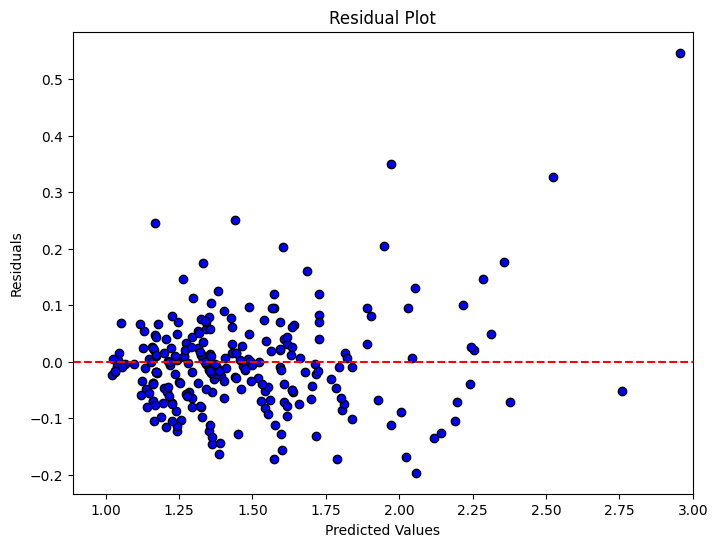

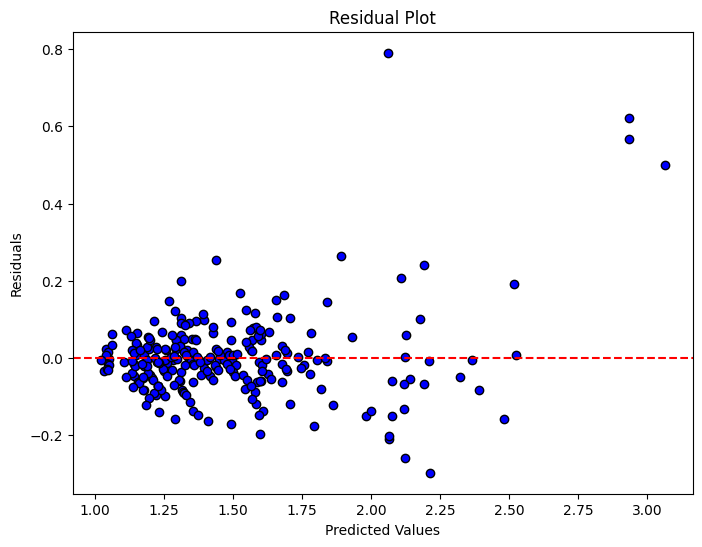

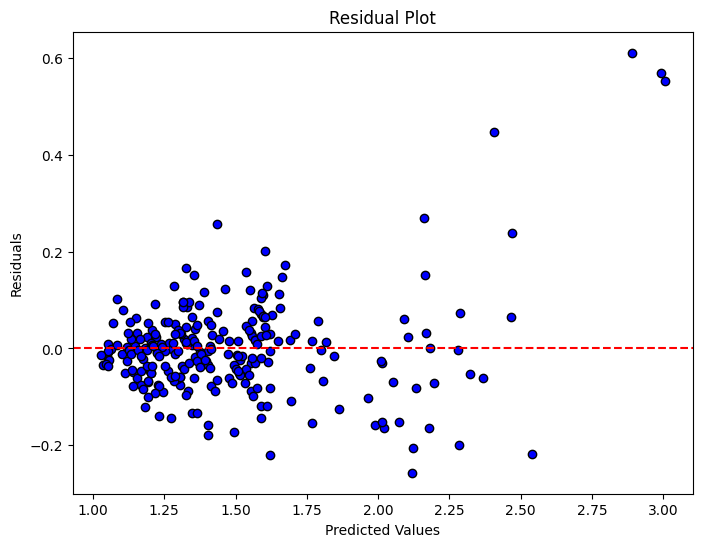

In [163]:
# Plotting the best three residuals
residuals_large = y_test_EDZ - predictions
plt.figure(figsize=(8, 6))
plt.scatter(predictions, residuals_large, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.xlim(None,3)
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

residuals_medium = y_test_EDZ - predictions_optimum3
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum3, residuals_medium, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

residuals_small = y_test_EDZ - predictions_optimum8
plt.figure(figsize=(8, 6))
plt.scatter(predictions_optimum8, residuals_small, color='b', edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


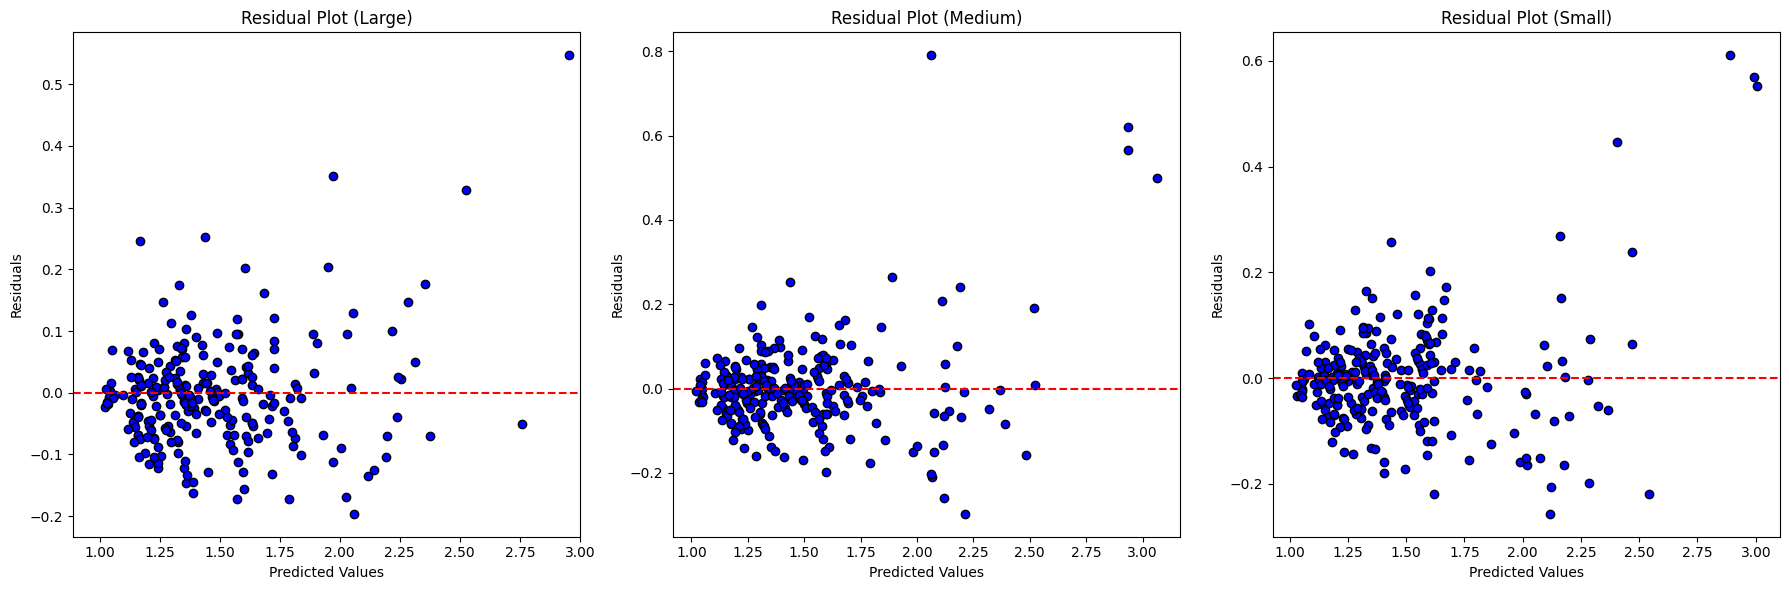

In [164]:
# Plotting the best three residuals in one figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting residuals_large
residuals_large = y_test_EDZ - predictions
axs[0].scatter(predictions, residuals_large, color='b', edgecolors='k')
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].set_xlabel('Predicted Values')
axs[0].set_xlim(None, 3)
axs[0].set_ylabel('Residuals')
axs[0].set_title('Residual Plot (Large)')

# Plotting residuals_medium
residuals_medium = y_test_EDZ - predictions_optimum3
axs[1].scatter(predictions_optimum3, residuals_medium, color='b', edgecolors='k')
axs[1].axhline(y=0, color='r', linestyle='--')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residual Plot (Medium)')

# Plotting residuals_small
residuals_small = y_test_EDZ - predictions_optimum8
axs[2].scatter(predictions_optimum8, residuals_small, color='b', edgecolors='k')
axs[2].axhline(y=0, color='r', linestyle='--')
axs[2].set_xlabel('Predicted Values')
axs[2].set_ylabel('Residuals')
axs[2].set_title('Residual Plot (Small)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

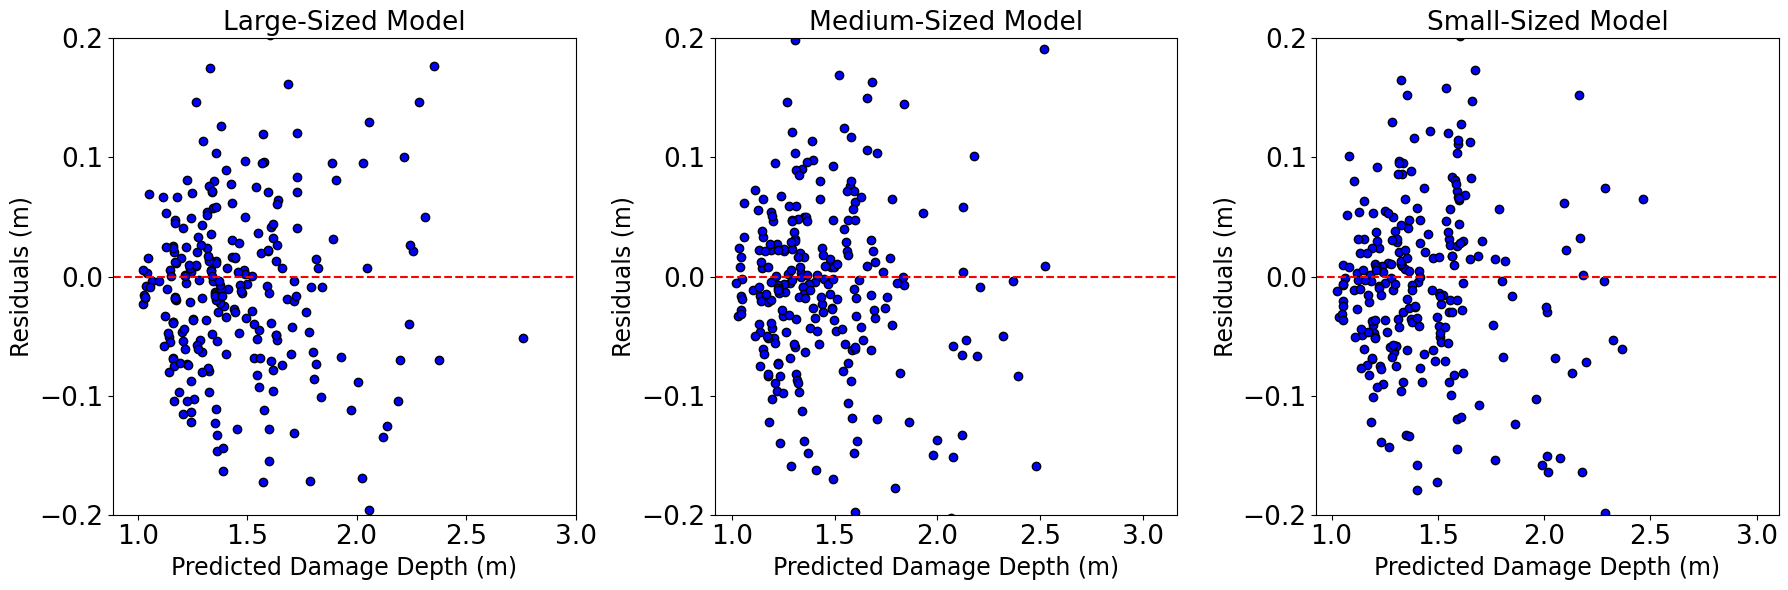

In [165]:
# Plotting the best three residuals in one figure
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting residuals_large
residuals_large = y_test_EDZ - predictions
axs[0].scatter(predictions, residuals_large, color='b', edgecolors='k')
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].set_xlabel('Predicted Damage Depth (m)', fontsize=17)
axs[0].set_xlim(None, 3)
axs[0].set_ylabel('Residuals (m)', fontsize=17)
axs[0].set_title('Large-Sized Model', fontsize=19)
axs[0].set_ylim(-0.2, 0.2)  # Set y-axis limits
axs[0].set_yticks(np.arange(-0.2,0.21, 0.1))
# Plotting residuals_medium
residuals_medium = y_test_EDZ - predictions_optimum3
axs[1].scatter(predictions_optimum3, residuals_medium, color='b', edgecolors='k')
axs[1].axhline(y=0, color='r', linestyle='--')
axs[1].set_xlabel('Predicted Damage Depth (m)', fontsize=17)
axs[1].set_ylabel('Residuals (m)', fontsize=17)
axs[1].set_title('Medium-Sized Model', fontsize=19)
axs[1].set_ylim(-0.2, 0.2)  # Set y-axis limits
axs[1].set_yticks(np.arange(-0.2,0.21, 0.1))

# Plotting residuals_small
residuals_small = y_test_EDZ - predictions_optimum8
axs[2].scatter(predictions_optimum8, residuals_small, color='b', edgecolors='k')
axs[2].axhline(y=0, color='r', linestyle='--')
axs[2].set_xlabel('Predicted Damage Depth (m)', fontsize=17)
axs[2].set_ylabel('Residuals (m)', fontsize=17)
axs[2].set_title('Small-Sized Model', fontsize=19)
axs[2].set_ylim(-0.2, 0.2)  # Set y-axis limits
axs[2].set_yticks(np.arange(-0.2,0.21, 0.1))

# Set x-axis and y-axis tick font size for all subplots
for ax in axs:
    ax.tick_params(axis='x', labelsize=19)  # Adjust the x-axis font size as needed
    ax.tick_params(axis='y', labelsize=19)  # Adjust the y-axis font size as needed

# Adjust layout
plt.tight_layout()

plt.savefig("Residual Plots for the best Models of different sizes.png", format="png", dpi=600, bbox_inches='tight')


# Show the plot
plt.show()